# MCMC experiment with various combinations of parameters

## Parameter Estimation in Bayesian Modeling and Demand Analysis

To estimate demand, we utilized the PyMC3 framework, a robust tool for constructing and inferring Bayesian statistical models. Our systematic approach began with data preprocessing using Theano tensors and culminated in defining and testing prior distributions for eta (η), a, and b. These parameters are crucial in demand analysis. PyMC3's strength in incorporating Poisson processes, as highlighted by Agrawal (2021), was particularly valuable for modeling demand in dynamic pricing and learning models.

## Bayesian Modeling Approach

### Data Preparation

Our dataset was organized chronologically and grouped by unique combinations of Source, Destination, and Car Type. Estimations focused on the price column for each combination.

### Demand Function Definition

We concentrated on the non-linear impacts of ETA on demand, modeled using gamma functions and accounting for Gaussian noise to define the likelihood function.

## Parameter Estimation via MCMC

### Sampling Methodology

Following the methodology of Mathias Leys (2023), we employed Markov Chain Monte Carlo (MCMC) techniques, iterating thousands of times to gather estimates of eta, a, and b, inclusive of parameter uncertainty.

### Visualization

Demand functions representing the averages of all samples were plotted, providing a clear visual representation of demand fluctuations with price changes.

## Trials and Results

Multiple trials were conducted to identify the most fitting distributions for each parameter.

---

### Figure 1. Progressive Estimations of Demand Function Using Thompson Sampling

<img src="../Pipeline/Visuals/demand_function.png" width="50%" height="auto">

Figure 15 illustrates the demand function estimated using Thompson sampling, updating eta parameters with each data point. Using the trace object from the PyMC3 library, the demand function estimate at each sampling step is represented by the gray line, showing convergence over time. The blue line represents the final estimated demand function, providing insights into the demand-price relationship. This demonstrates effective utilization of real-time data for dynamic pricing and demand forecasting.

---

### Table 1. Eta (η) Estimation

| Trial | Eta (η) Distribution | a Parameter Distribution | b Parameter Distribution |
|-------|----------------------|--------------------------|--------------------------|
| 1st   | Gamma (shape=2, scale=⅕) | Uniform (0 to 100)  | Uniform (0 to 20)    |
| 2nd   | Gamma (shape=3, scale=⅙) | Uniform (0 to 70)   | Uniform (4 to 40)    |
| 3rd   | Uniform (0 to 2)     | Uniform (0 to 10)   | Uniform (4 to 70)    |
| 4th   | Gamma (shape=2, scale=⅕) | Uniform (0 to 10)   | Uniform (4 to 70)    |

Initial Approach: A gamma distribution (Michael Kozak, 2020) was assumed, conducting several experiments with varying shape and scale parameters. The third trial shifted to a uniform distribution to identify potential skews, later approximating it with the closest gamma distribution. The first version (Gamma distribution, shape=2, scale=⅕) was found to be the most effective after reviewing consistency and performance against actual prices, adopted in the 4th trial.

---

### Figures 2 & 3. Gamma Distribution and Histogram of Simulated eta Values
<img src="../Pipeline/Visuals/gamma_distribution.png" width="50%" height="auto">
<img src="../Pipeline/Visuals/eta_histogram_plot.png" width="50%" height="auto">


Figure 2 displays a gamma distribution with initial settings of a shape parameter of 2 and a rate parameter of 5, chosen based on research indicating eta's adherence to a gamma distribution. Figure 3 shows a histogram of eta values from our MCMC simulation in trial one, aligning with the gamma distribution and indicating a median range concentration. Due to slight deviations from the gamma distribution, a uniform distribution was tested in trial three, but the gamma distribution proved more effective.

## a and b Estimation

a Parameter: Initially a uniform distribution ranging from 0 to 100, gradually narrowed based on MCMC findings.

b Parameter: Started with a range of 0 to 20, with incremental upper limit adjustments to pinpoint the exact distribution.

Conclusive Trends: Both parameters a and b showed converging trends, leading to the adoption of parameters from the third trial.

---

### Figures 4 & 5. Distribution of Estimated Parameters a and b in Trial 1

<img src="../Pipeline/Visuals/a_histogram_plot.png" width="50%" height="auto">
<img src="../Pipeline/Visuals/b_histogram_plot.png" width="50%" height="auto">

Figure 4 and Figure 5 depict the distribution of estimates for parameters a and b from MCMC simulations. In Figure 4, parameter a's estimates cluster around a low value, indicating stability. Conversely, parameter b's estimates in Figure 5 spread over a wider range, suggesting variability in the lower bound b in demand forecasting. These parameters inform adjustments during the optimization process.


In [1]:
import streamlit as st
import pandas as pd
from preprocess import get_base_data, get_dynamic_data
from train import prepare_data, train_and_save_model

In [9]:
from preprocess import get_base_data, get_dynamic_data
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
import joblib
from joblib import dump
from joblib import load

In [1]:
import pandas as pd

# Function to load and preprocess cab ride data
def load_and_preprocess_cab_data(filepath):
    """
    Load cab ride data from a CSV file and preprocess it.
    Args:
        filepath (str): The path to the cab ride data CSV file.
    Returns:
        DataFrame: Preprocessed cab ride data.
    """
    try:
        data_df = pd.read_csv(filepath)
        data_df = data_df[data_df['name'] != 'Taxi']
        data_df['date_time'] = pd.to_datetime(data_df['time_stamp'], unit='ms')
        data_df['car_type'] = data_df['name'].apply(determine_car)
        data_df['weekday'] = data_df['date_time'].dt.weekday.apply(lambda x: 1 if 0 <= x <= 4 else 0)
        data_df['rush_hour'] = data_df['date_time'].apply(is_rush_hour)
        return data_df
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None

# Function to determine car type
def determine_car(car):
    car_mapping = {
        "Black": "Luxury", "Lux Black": "Luxury", "Lux": "Luxury",
        "Black SUV": "Luxury SUV", "Lux Black XL": "Luxury SUV",
        "UberX": "Base", "Lyft": "Base",
        "UberXL": "Base XL", "Lyft XL": "Base XL",
        "UberPool": "Shared", "Shared": "Shared",
        "WAV": "Wheel Chair Accessible"
    }
    return car_mapping.get(car, "Other")

# Function to check if it's rush hour
def is_rush_hour(time_obj):
    morning_rush = time_obj.hour in range(7, 10)
    evening_rush = time_obj.hour in range(16, 19)
    return int(morning_rush or evening_rush)

# Function to load and preprocess weather data
def load_and_preprocess_weather_data(filepath):
    """
    Load weather data from a CSV file and preprocess it.
    Args:
        filepath (str): The path to the weather data CSV file.
    Returns:
        DataFrame: Preprocessed weather data.
    """
    try:
        weather_df = pd.read_csv(filepath)
        weather_df['date_time'] = pd.to_datetime(weather_df['time_stamp'], unit='s')
        weather_df['is_raining'] = weather_df['rain'].apply(lambda x: 1 if x > 0 else 0)
        weather_df['temp_groups'] = weather_df['temp'].apply(group_temp)
        return weather_df
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None

# Function to group temperature
def group_temp(temp):
    temp_ranges = [(30, 20), (40, 30), (50, 40), (float('inf'), 50)]
    for upper_bound, group in temp_ranges:
        if temp < upper_bound:
            return group

# Function to merge and clean datasets
def merge_and_clean_data(ride_data, weather_data):
    """
    Merge and clean ride and weather datasets.
    Args:
        ride_data (DataFrame): Preprocessed ride data.
        weather_data (DataFrame): Preprocessed weather data.
    Returns:
        DataFrame: Merged and cleaned dataset.
    """
    merged_df = pd.merge_asof(ride_data.sort_values('date_time'), 
                              weather_data.sort_values('date_time'), 
                              on='date_time', 
                              left_by='source', 
                              right_by='location',
                              direction='nearest')

    final_columns = [
        'date_time', 'distance', 'cab_type', 'source', 'destination',
        'car_type', 'weekday', 'rush_hour', 'is_raining', 'temp_groups',
        'surge_multiplier', 'price',
    ]

    return merged_df[final_columns]

# Function to get main data 
def get_cleaned_data():
    """
    Loads, merges, and cleans the main datasets.
    Returns:
        DataFrame: The cleaned data.
    """
    data_df = load_and_preprocess_cab_data("Data/cab_rides.csv")
    weather_df = load_and_preprocess_weather_data("Data/weather.csv")
    if data_df is not None and weather_df is not None:
        return merge_and_clean_data(data_df, weather_df)
    else:
        raise ValueError("Error in loading data.")
    
# Function to get base modeling data
def get_base_data():
    """
    Extract base data where surge_multiplier is 1.0.
    Returns:
        DataFrame: Filtered base data.
    """
    df = get_cleaned_data()
    base_df = df[df["surge_multiplier"] == 1.0]
    return base_df[["cab_type", "source", "destination", "car_type", "weekday", "rush_hour", "is_raining", "temp_groups", "surge_multiplier", "price"]]

# Function to get dynamic modeling data 
def get_dynamic_data():
    """
    Extract dynamic data.
    Returns:
        DataFrame: Filtered dynamic data.
    """
    df = get_cleaned_data()
    return df[["cab_type", "source", "destination", "car_type", "weekday", "rush_hour", "is_raining", "temp_groups", "surge_multiplier", "price"]]

# NOT YET FUNCTIONAL
# def get_demand_data():
#     """
#     Create dataset based off demand estimation calculation.
#     Returns:
#         DataFrame: Filtered Demand data.
#     """
#     df = get_cleaned_data()
#     demand_df = demand_estimation(df)
#     return demand_df[[set of columns to keep]]

# Main script execution
if __name__ == "__main__":
    data_df = load_and_preprocess_cab_data("Data/cab_rides.csv")
    weather_df = load_and_preprocess_weather_data("Data/weather.csv")

    if data_df is not None and weather_df is not None:
        merged_df = merge_and_clean_data(data_df, weather_df)
        # Save the cleaned data
        merged_df.to_csv("Data/base_cleaned.csv")
    

In [10]:
cleaned_df = get_cleaned_data()
print(cleaned_df.shape)
cleaned_df.head()

(637976, 12)


date_time  distance cab_type                   source  \
0 2018-11-26 03:40:46.318      3.03     Lyft        Boston University   
1 2018-11-26 03:40:46.319      1.30     Uber            South Station   
2 2018-11-26 03:40:46.320      2.43     Lyft  Northeastern University   
3 2018-11-26 03:40:46.320      2.71     Uber         Theatre District   
4 2018-11-26 03:40:46.320      2.71     Uber         Theatre District   

        destination    car_type  weekday  rush_hour  is_raining  temp_groups  \
0  Theatre District  Luxury SUV        1          0           0           40   
1  Theatre District      Luxury        1          0           0           40   
2       Beacon Hill        Base        1          0           0           40   
3            Fenway     Base XL        1          0           0           40   
4            Fenway        Base        1          0           0           40   

   surge_multiplier  price  
0               1.0   34.0  
1               1.0   18.5  
2               1.0   10.5  
3               1.0   32.0  
4               1.0   19.5

In [11]:
base_df = get_base_data()
print(base_df.shape)
base_df.head()

(617001, 10)


cab_type                   source       destination    car_type  weekday  \
0     Lyft        Boston University  Theatre District  Luxury SUV        1   
1     Uber            South Station  Theatre District      Luxury        1   
2     Lyft  Northeastern University       Beacon Hill        Base        1   
3     Uber         Theatre District            Fenway     Base XL        1   
4     Uber         Theatre District            Fenway        Base        1   

   rush_hour  is_raining  temp_groups  surge_multiplier  price  
0          0           0           40               1.0   34.0  
1          0           0           40               1.0   18.5  
2          0           0           40               1.0   10.5  
3          0           0           40               1.0   32.0  
4          0           0           40               1.0   19.5

In [14]:
base_df[base_df['cab_type'] == 'Uber']['car_type'].unique()

array(['Luxury', 'Base XL', 'Base', 'Wheel Chair Accessible',
       'Luxury SUV', 'Shared'], dtype=object)

In [15]:
base_df[base_df['cab_type'] == 'Lyft']['car_type'].unique()

array(['Luxury SUV', 'Base', 'Shared', 'Luxury', 'Base XL'], dtype=object)

In [12]:
dynamic_df = get_dynamic_data()
print(dynamic_df.shape)
dynamic_df.head()

(637976, 10)


cab_type                   source       destination    car_type  weekday  \
0     Lyft        Boston University  Theatre District  Luxury SUV        1   
1     Uber            South Station  Theatre District      Luxury        1   
2     Lyft  Northeastern University       Beacon Hill        Base        1   
3     Uber         Theatre District            Fenway     Base XL        1   
4     Uber         Theatre District            Fenway        Base        1   

   rush_hour  is_raining  temp_groups  surge_multiplier  price  
0          0           0           40               1.0   34.0  
1          0           0           40               1.0   18.5  
2          0           0           40               1.0   10.5  
3          0           0           40               1.0   32.0  
4          0           0           40               1.0   19.5

Reverse Eng

In [2]:
import pandas as pd

In [4]:
eta_df = pd.read_csv('Data/estimated_eta_added.csv')

surge_eta_df = eta_df[eta_df['surge_multiplier'] != 1.0]
no_surge_eta_df = eta_df[eta_df['surge_multiplier'] == 1.0]

### price = base_price * (1 + estimated_eta * estimated_demand)
### base_price = price / (1 + estimated_eta * estimated_demand)

def rev_base_price(row):
    return row['price'] / (1 + row['estimated_eta'] * row['estimated_demand'])

surge_eta_df['base_price'] = surge_eta_df.apply(rev_base_price, axis=1)
no_surge_eta_df['base_price'] = no_surge_eta_df.apply(rev_base_price, axis=1)

surge_eta_df['price_diff'] = surge_eta_df['price'] - surge_eta_df['base_price']
no_surge_eta_df['price_diff'] = no_surge_eta_df['price'] - no_surge_eta_df['base_price']

/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_25839/2156326977.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surge_eta_df['base_price'] = surge_eta_df.apply(rev_base_price, axis=1)
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_25839/2156326977.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_surge_eta_df['base_price'] = no_surge_eta_df.apply(rev_base_price, axis=1)
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_25839/2156326977.py:15: SettingWithCopyWarnin

In [5]:
surge_eta_df['price_diff'].describe()

count    20975.000000
mean         9.531648
std          9.358192
min          0.087162
25%          0.494316
50%          8.630501
75%         17.444087
max         58.279945
Name: price_diff, dtype: float64

In [6]:
no_surge_eta_df['price_diff'].describe()

count    617001.000000
mean          7.059071
std           5.531686
min           0.050287
25%           1.154406
50%           6.759392
75%          10.938054
max          54.178585
Name: price_diff, dtype: float64

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Data/base_cleaned.csv')
df.head()

Unnamed: 0                date_time  distance cab_type  \
0           0  2018-11-26 03:40:46.318      3.03     Lyft   
1           1  2018-11-26 03:40:46.319      1.30     Uber   
2           2  2018-11-26 03:40:46.320      2.43     Lyft   
3           3  2018-11-26 03:40:46.320      2.71     Uber   
4           4  2018-11-26 03:40:46.320      2.71     Uber   

                    source       destination    car_type  weekday  rush_hour  \
0        Boston University  Theatre District  Luxury SUV        1          0   
1            South Station  Theatre District      Luxury        1          0   
2  Northeastern University       Beacon Hill        Base        1          0   
3         Theatre District            Fenway     Base XL        1          0   
4         Theatre District            Fenway        Base        1          0   

   is_raining  temp_groups  surge_multiplier  price  
0           0           40               1.0   34.0  
1           0           40               1.0   18.5  
2           0           40               1.0   10.5  
3           0           40               1.0   32.0  
4           0           40               1.0   19.5

In [3]:
df['temp_groups'].unique()

array([40, 30, 20, 50])

In [5]:
new_df = pd.read_csv('Data/demand_est.csv')
new_df.head()

distance cab_type         source        destination          name  \
0      3.01     Uber  North Station  Boston University     Black SUV   
1      3.01     Uber  North Station  Boston University     Black SUV   
2      3.01     Uber  North Station  Boston University     Black SUV   
3      3.15     Lyft  North Station  Boston University  Lux Black XL   
4      3.09     Lyft  North Station  Boston University  Lux Black XL   

     car_type  weekday  rush_hour   temp  clouds  ...  humidity  wind  \
0  Luxury SUV        1          0  40.51    1.00  ...      0.92  1.35   
1  Luxury SUV        1          0  40.51    1.00  ...      0.92  1.35   
2  Luxury SUV        1          0  40.54    1.00  ...      0.92  1.42   
3  Luxury SUV        1          1  41.10    0.97  ...      0.92  1.82   
4  Luxury SUV        1          1  41.10    0.97  ...      0.92  1.82   

   is_raining  temp_groups  surge_multiplier  price  estimated_eta  \
0           0           40               1.0   35.0       0.000301   
1           0           40               1.0   32.5       0.000301   
2           0           40               1.0   35.0       0.000301   
3           0           40               1.0   34.0       0.000301   
4           0           40               1.0   32.5       0.000301   

   estimated_a  estimated_b  estimated_demand  
0    34.518257     19.99128         54.472641  
1    34.518257     19.99128         54.473410  
2    34.518257     19.99128         54.472641  
3    34.518257     19.99128         54.472942  
4    34.518257     19.99128         54.473410  

[5 rows x 22 columns]

In [6]:
import pymc3 as pm
import numpy as np
import theano

In [9]:
theano.__version__

'1.1.2'

In [2]:
import sklearn
sklearn.__version__

'1.1.2'

In [4]:
import pandas as pd

In [5]:
def get_demand_data(data=pd.read_csv("Data/demand_est.csv")):
    """
    Create dataset based off demand estimation calculation.
    Returns:
        DataFrame: Filtered Demand data.
    """
    # Load in already saved data because it takes hours to do the demand estimation
    df = data
    df['estimated_demand'] = df['estimated_a'] * np.exp(-np.abs(df['estimated_eta']) * np.log(df['price'])) + df['estimated_b']
    df['base_price'] = df.groupby(by=['source', 'destination', 'car_type'])['price'].transform('min')
    df.rename(columns = {'price': 'original_price'}, inplace= True)
    # Now the new price column will actually be the dynamic price
    df['price'] = df['base_price'] * (1 + df['estimated_eta'] * df['estimated_demand'])
    return df[["cab_type", "source", "destination", "car_type", "weekday", "rush_hour", "is_raining", "temp_groups", "price"]]


In [7]:
import numpy as np

In [8]:
demand_df = get_demand_data()
demand_df.head()

cab_type         source        destination    car_type  weekday  rush_hour  \
0     Uber  North Station  Boston University  Luxury SUV        1          0   
1     Uber  North Station  Boston University  Luxury SUV        1          0   
2     Uber  North Station  Boston University  Luxury SUV        1          0   
3     Lyft  North Station  Boston University  Luxury SUV        1          1   
4     Lyft  North Station  Boston University  Luxury SUV        1          1   

   is_raining  temp_groups      price  
0           0           40  28.966981  
1           0           40  28.966987  
2           0           40  28.966981  
3           0           40  28.966983  
4           0           40  28.966987

In [9]:
### For test by YC ###
def get_demand_data_with_eta(data=pd.read_csv("Data/demand_est.csv")):
    """
    Create dataset based off demand estimation calculation.
    Returns:
        DataFrame: Filtered Demand data.
    """
    # Load in already saved data because it takes hours to do the demand estimation
    df = data
    df['estimated_demand'] = df['estimated_a'] * np.exp(-np.abs(df['estimated_eta']) * np.log(df['price'])) + df['estimated_b']
    df['base_price'] = df.groupby(by=['source', 'destination', 'car_type'])['price'].transform('min')
    df.rename(columns = {'price': 'original_price'}, inplace= True)
    # Now the new price column will actually be the dynamic price
    df['price'] = df['base_price'] * (1 + df['estimated_eta'] * df['estimated_demand'])
    return df[["cab_type", "source", "destination", "car_type", "weekday", "rush_hour", "is_raining", "temp_groups", "price", "estimated_eta", "estimated_a", "estimated_b"]]


In [11]:
new_df = get_demand_data_with_eta()
new_df.sample(10)

cab_type            source              destination  \
617760     Uber     South Station                 Back Bay   
115933     Lyft          West End        Boston University   
466263     Uber  Haymarket Square         Theatre District   
513042     Lyft          Back Bay  Northeastern University   
266428     Lyft            Fenway                 West End   
201492     Lyft     South Station              Beacon Hill   
130119     Lyft          Back Bay            South Station   
278737     Lyft  Theatre District         Haymarket Square   
586736     Lyft  Haymarket Square                 West End   
203811     Uber         North End                 West End   

                      car_type  weekday  rush_hour  is_raining  temp_groups  \
617760                  Luxury        0          0           0           40   
115933                  Shared        1          0           0           40   
466263  Wheel Chair Accessible        0          0           0           50   
513042                  Luxury        1          0           1           40   
266428                 Base XL        1          0           0           20   
201492                  Shared        0          0           0           30   
130119                  Shared        1          0           0           30   
278737                 Base XL        0          0           0           40   
586736                  Luxury        1          0           1           40   
203811                  Shared        1          0           0           40   

              price  estimated_eta  estimated_a  estimated_b  
617760    16.838657       0.000357     8.639547    19.997327  
115933    74.038770       0.468518     0.008086     8.466761  
466263   185.707573       0.516382     0.064533     8.402251  
513042  1095.126302       0.603654     0.017516    15.259849  
266428  2557.654232       0.743238     0.349898    17.512869  
201492    66.814090       0.470843     0.007920     7.896953  
130119    60.295027       0.459306     0.003124     8.514198  
278737  1056.614069       0.633149     0.067695    14.258783  
586736   874.903560       0.564868     0.014934    14.388013  
203811    30.376465       0.420876     0.007231     5.903615

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Data/demand_est.csv')

In [5]:
df.head()

distance cab_type         source        destination          name  \
0      3.01     Uber  North Station  Boston University     Black SUV   
1      3.01     Uber  North Station  Boston University     Black SUV   
2      3.01     Uber  North Station  Boston University     Black SUV   
3      3.15     Lyft  North Station  Boston University  Lux Black XL   
4      3.09     Lyft  North Station  Boston University  Lux Black XL   

     car_type  weekday  rush_hour   temp  clouds  ...  humidity  wind  \
0  Luxury SUV        1          0  40.51    1.00  ...      0.92  1.35   
1  Luxury SUV        1          0  40.51    1.00  ...      0.92  1.35   
2  Luxury SUV        1          0  40.54    1.00  ...      0.92  1.42   
3  Luxury SUV        1          1  41.10    0.97  ...      0.92  1.82   
4  Luxury SUV        1          1  41.10    0.97  ...      0.92  1.82   

   is_raining  temp_groups  surge_multiplier  price  estimated_eta  \
0           0           40               1.0   35.0       0.000301   
1           0           40               1.0   32.5       0.000301   
2           0           40               1.0   35.0       0.000301   
3           0           40               1.0   34.0       0.000301   
4           0           40               1.0   32.5       0.000301   

   estimated_a  estimated_b  estimated_demand  
0    34.518257     19.99128         54.472641  
1    34.518257     19.99128         54.473410  
2    34.518257     19.99128         54.472641  
3    34.518257     19.99128         54.472942  
4    34.518257     19.99128         54.473410  

[5 rows x 22 columns]

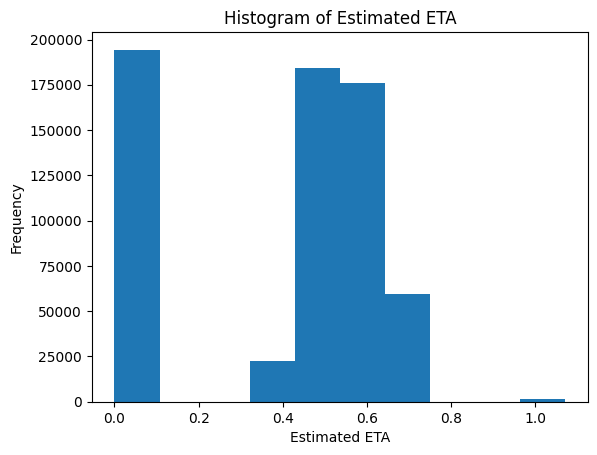

In [6]:
# Make a histogram of 'estimated_eta' column
plt.hist(df['estimated_eta'])
plt.xlabel('Estimated ETA')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated ETA')
plt.show()

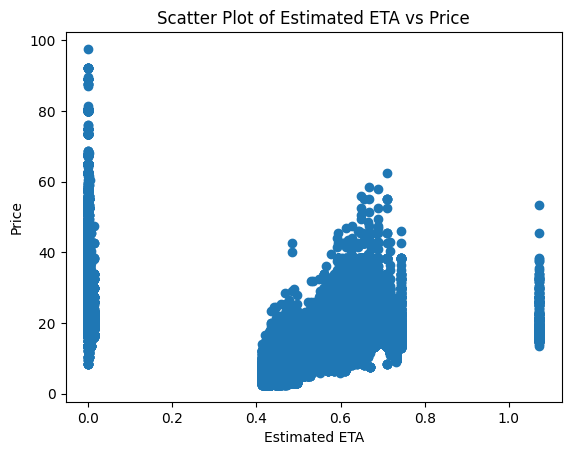

In [7]:
# Make a scatter plot of 'estimated_eta' vs 'price'
plt.scatter(df['estimated_eta'], df['price'])
plt.xlabel('Estimated ETA')
plt.ylabel('Price')
plt.title('Scatter Plot of Estimated ETA vs Price')
plt.show()


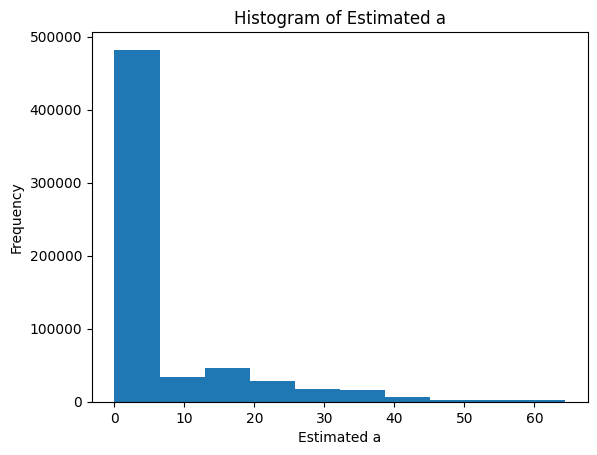

In [8]:
# Make a histogram of 'estimated_a' column
plt.hist(df['estimated_a'])
plt.xlabel('Estimated a')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated a')
plt.show()

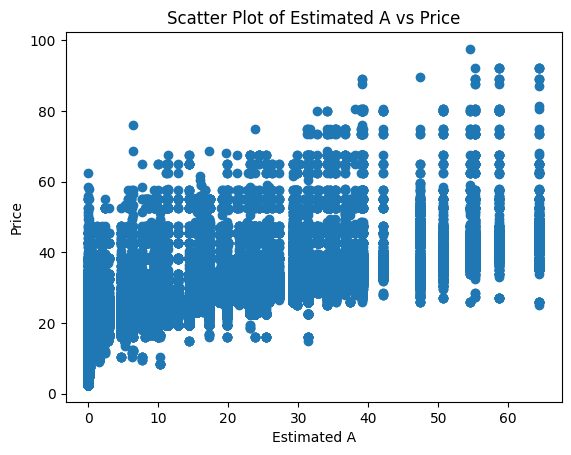

In [6]:
# Make a scatter plot with 'estimated_a' as the x-axis and 'price' as the y-axis
plt.scatter(df['estimated_a'], df['price'])
plt.xlabel('Estimated A')
plt.ylabel('Price')
plt.title('Scatter Plot of Estimated A vs Price')
plt.show()


In [14]:
# Do linear regression on 'estimated_b' and 'price'
# And get the slope and intercept
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df[['estimated_a']], df[['price']])
slope = model.coef_[0][0]
intercept = model.intercept_[0]
print(f"slope: {slope}, intercept: {intercept}")

slope: 0.6810391473144057, intercept: 12.63600445420885


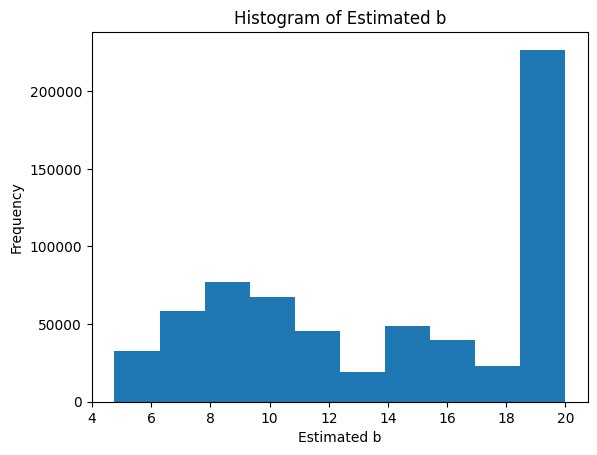

In [9]:
# Make a histogram of 'estimated_b' column
plt.hist(df['estimated_b'])
plt.xlabel('Estimated b')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated b')
plt.show()

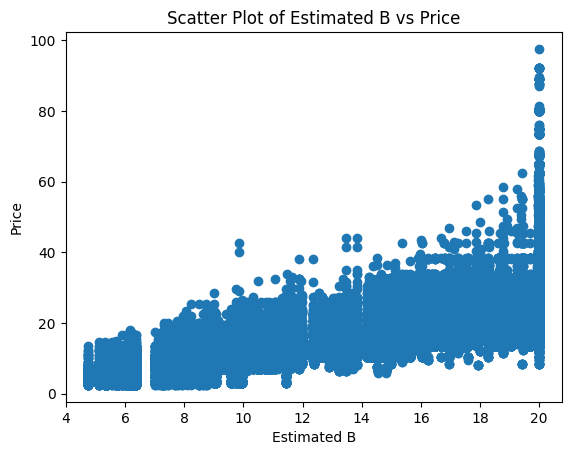

In [7]:
# Make a scatter plot with 'estimated_b' as the x-axis and 'price' as the y-axis
plt.scatter(df['estimated_b'], df['price'])
plt.xlabel('Estimated B')
plt.ylabel('Price')
plt.title('Scatter Plot of Estimated B vs Price')
plt.show()


In [13]:
# Do linear regression on 'estimated_b' and 'price'
# And get the slope and intercept
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df[['estimated_b']], df[['price']])
slope = model.coef_[0][0]
intercept = model.intercept_[0]
print(f"slope: {slope}, intercept: {intercept}")

slope: 1.544766430604428, intercept: -5.215191464577099


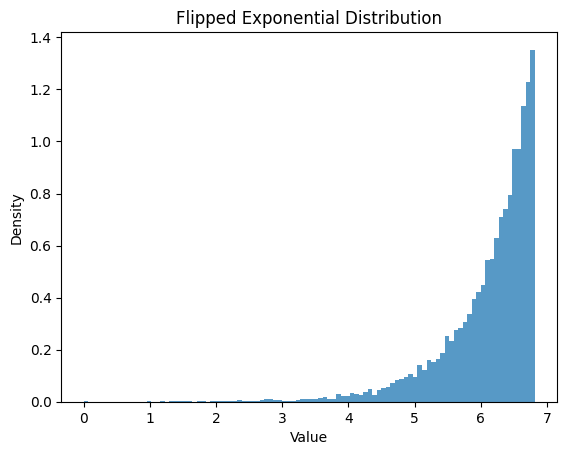

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the distribution
scale = 0.7  # Scale parameter for the exponential distribution
size = 10000  # Number of samples

# Generate exponential distribution samples
exp_samples = np.random.exponential(scale, size)

# Since we want to "flip" the exponential distribution, we can take the max of the samples
# and subtract the original samples from this max value.
flipped_samples = np.max(exp_samples) - exp_samples

# Plot the histogram of the flipped exponential distribution
plt.hist(flipped_samples, bins=100, density=True, alpha=0.75)

plt.title('Flipped Exponential Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


In [38]:
new_df = pd.read_csv('Data/base_cleaned.csv')
new_df.head()

Unnamed: 0                date_time  distance cab_type  \
0           0  2018-11-26 03:40:46.318      3.03     Lyft   
1           1  2018-11-26 03:40:46.319      1.30     Uber   
2           2  2018-11-26 03:40:46.320      2.43     Lyft   
3           3  2018-11-26 03:40:46.320      2.71     Uber   
4           4  2018-11-26 03:40:46.320      2.71     Uber   

                    source       destination    car_type  weekday  rush_hour  \
0        Boston University  Theatre District  Luxury SUV        1          0   
1            South Station  Theatre District      Luxury        1          0   
2  Northeastern University       Beacon Hill        Base        1          0   
3         Theatre District            Fenway     Base XL        1          0   
4         Theatre District            Fenway        Base        1          0   

   is_raining  temp_groups  surge_multiplier  price  
0           0           40               1.0   34.0  
1           0           40               1.0   18.5  
2           0           40               1.0   10.5  
3           0           40               1.0   32.0  
4           0           40               1.0   19.5

In [1]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from preprocess import *

def load_MCMC_df(data=pd.read_csv('Data/base_cleaned.csv')):
    if "Unnamed: 0" in data.columns: 
        data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    if "date_time" in data.columns: 
        data = data.set_index('date_time')
        data = data.sort_index()
    return data

def estimate_demand_parameters(dataframe, price_col='price', suffix=''):
    """
    Estimates the demand parameters (eta, a, b) using PyMC3 and adds them as new columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data
    :param price_col: Name of the column containing price data
    :return: DataFrame with new columns for eta, a, b estimates
    """
    df_copy = dataframe.copy()
    df_copy[price_col] = pd.to_numeric(df_copy[price_col], errors='coerce').fillna(0)

    with pm.Model() as model:
        ##### Define priors
        ### Set the prior for eta to be a Gamma distribution with shape=2 and rate=5
        eta_shape = 2   # 모양 매개변수
        eta_rate = 5    # 비율 매개변수
        eta = pm.Gamma('eta', alpha=eta_shape, beta=eta_rate) + 0.25

        ### Set the priors for a and b
        # a = pm.Uniform('a', lower=0, upper=100)

        ### Configuration for a
        slope_a = 0.6810391473144057
        intercept_a = 12.63600445420885
        x_lower_a = 0.1
        x_upper_a = 70
        x_range_a = np.linspace(x_lower_a, x_upper_a, 1000)
        # Calculate the normalization constant for the PDF over the range of x for a
        # This is the area under the curve from x_lower_a to x_upper_a
        def integral_linear_for_a(x, m, a):
            return 0.5 * m * x**2 + a * x
        normalization_constant_a = integral_linear_for_a(x_upper_a, slope_a, intercept_a) - integral_linear_for_a(x_lower_a, slope_a, intercept_a)

        def linear_pdf_for_a(x):
            linear_term = slope_a * x + intercept_a
            return tt.switch(tt.and_(x >= x_lower_a, x <= x_upper_a), tt.maximum(0, linear_term), 0) / normalization_constant_a

        # Define a bounded continuous uniform distribution for x
        x_a = pm.Uniform('x_a_'+suffix, lower=x_lower_a, upper=x_upper_a)
        # Define the normalized custom linear PDF using DensityDist
        a = pm.DensityDist('a', lambda value: linear_pdf_for_a(value), observed={'value': x_a})
        

        # b = pm.Uniform('b', lower=0, upper=20)
        ### Configuration for b
        slope_b = 1.544766430604428
        intercept_b = -5.215191464577099
        x_lower_b = 4
        x_upper_b = 20
        x_range_b = np.linspace(x_lower_b, x_upper_b, 1000)

        # 선형 함수의 적분을 계산하는 함수
        def integral_linear_for_b(x, m, b):
            return 0.5 * m * x**2 + b * x

        # Calculate the normalization constant for b
        # This is the area under the curve from x_lower_b to x_upper_b
        normalization_constant_b = integral_linear_for_b(x_upper_b, slope_b, intercept_b) - integral_linear_for_b(x_lower_b, slope_b, intercept_b)

        # 사용자 정의 확률 밀도 함수 (PDF) 정의
        def linear_pdf_for_b(x):
            linear_term = slope_b * x + intercept_b
            return tt.switch(tt.and_(x >= x_lower_b, x <= x_upper_b), tt.maximum(0, linear_term), 0) / normalization_constant_b

        x_b = pm.Uniform('x_b_'+suffix, lower=x_lower_b, upper=x_upper_b)
        # PyMC3 모델에서 사용
        b = pm.DensityDist('b', lambda value: linear_pdf_for_b(value), observed={'value': x_b})


        ### Price!
        # Convert the price data to a theano tensor
        # price_data = tt.as_tensor_variable(dataframe[price_col].values)
        price_data = tt.as_tensor_variable(df_copy[price_col].values)

        # Define the demand function using pm.math.exp for exponentiation
        demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b

        # Assuming Gaussian noise in the observed data
        observed = pm.Normal('observed', mu=demand, sd=1, observed=dataframe[price_col])

        # Sample from the posterior
        # trace = pm.sample(1000, tune=1000, return_inferencedata=False)
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)


    # Extracting the mean of the posterior distributions
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # Adding new columns to the dataframe
    # dataframe['estimated_eta'] = eta_mean
    # dataframe['estimated_a'] = a_mean
    # dataframe['estimated_b'] = b_mean
    df_copy['estimated_eta'] = eta_mean
    df_copy['estimated_a'] = a_mean
    df_copy['estimated_b'] = b_mean

    return df_copy, trace

def save_demand_data(data=load_MCMC_df()):
    lst_car_type = list(set(data.car_type))
    lst_source = list(set(data.source))
    lst_destination = list(set(data.destination))

    results_list = []

    # 모든 조합에 대해 반복
    for car_type in lst_car_type:
        for source in lst_source:
            for destination in lst_destination:
                # 데이터 필터링
                filtered_data = data[(data['car_type'] == car_type) & (data['source'] == source) & (data['destination'] == destination)]

                # 필터링된 데이터가 비어있지 않은 경우에만 처리
                if not filtered_data.empty:
                    try:
                        # 고유 식별자 생성
                        suffix = f"{car_type}_{source}_{destination}".replace(' ', '_')
                        # 함수 호출
                        result_df, _ = estimate_demand_parameters(filtered_data, 'price')
                        # 결과 데이터프레임을 리스트에 추가
                        results_list.append(result_df)
                    except Exception as e:
                        print(f"Error processing combination: CarType={car_type}, Source={source}, Destination={destination}")
                        print(f"Error message: {e}")

    # 모든 결과 데이터프레임을 하나로 결합
    combined_df = pd.concat(results_list, ignore_index=True)
    combined_df.to_csv("Data/demand_est_test1.csv", index=False)


In [2]:
save_demand_data()

Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=Boston University
Error message: Unsupported dtype for TensorType: object
Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=Haymarket Square
Error message: Unsupported dtype for TensorType: object
Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=South Station
Error message: Unsupported dtype for TensorType: object
Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=Northeastern University
Error message: Unsupported dtype for TensorType: object
Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=Fenway
Error message: Unsupported dtype for TensorType: object
Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=North End
Error message: Unsupported dtype for TensorType: object
Error processing combination: CarType=Luxury SUV, Source=Beacon Hill, Destination=Boston University


KeyboardInterrupt: 

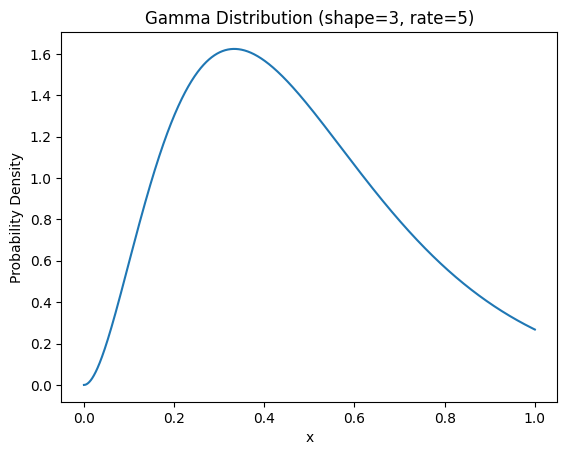

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# 감마 분포의 모양 변수(shape parameter)와 비율 변수(rate parameter)
shape = 3
rate = 6
scale = 1 / rate  # 스케일 파라미터는 rate의 역수입니다.

# x의 범위: 0부터 1까지
x = np.linspace(0, 1, 1000)

# 감마 분포의 확률 밀도 함수(PDF) 계산
y = gamma.pdf(x, a=shape, scale=scale)

# 차트 그리기
plt.plot(x, y)
plt.title('Gamma Distribution (shape=3, rate=5)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()



In [14]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from preprocess import *

def load_MCMC_df(data=pd.read_csv('Data/base_cleaned.csv')):
    if "Unnamed: 0" in data.columns: 
        data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    if "date_time" in data.columns: 
        data = data.set_index('date_time')
        data = data.sort_index()
    return data

def estimate_demand_parameters(dataframe, price_col='price'):
    """
    Estimates the demand parameters (eta, a, b) using PyMC3 and adds them as new columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data
    :param price_col: Name of the column containing price data
    :return: DataFrame with new columns for eta, a, b estimates
    """
    with pm.Model() as model:
        # Define priors
        # eta에 대한 감마 분포 정의, 평균이 0.4~0.5가 되도록 조정
        eta_shape = 3   # 모양 매개변수
        eta_rate = 6    # 비율 매개변수
        ### Set the prior for eta to be a Gamma distribution with shape=2 and rate=5
        eta = pm.Gamma('eta', alpha=eta_shape, beta=eta_rate)

        ### Set the priors for a and b
        a = pm.Uniform('a', lower=0, upper=70)
        b = pm.Uniform('b', lower=4, upper=40)

        # Convert the price data to a theano tensor
        price_data = tt.as_tensor_variable(dataframe[price_col].values)

        surge_multiplier_data = tt.as_tensor_variable(dataframe['surge_multiplier'].values)
        # Define the demand function using pm.math.exp for exponentiation
        demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b

        # Assuming Gaussian noise in the observed data
        observed = pm.Normal('observed', mu=demand, sd=1, observed=dataframe[price_col])

        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)

    # Extracting the mean of the posterior distributions
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # Adding new columns to the dataframe
    dataframe['estimated_eta'] = eta_mean
    dataframe['estimated_a'] = a_mean
    dataframe['estimated_b'] = b_mean

    return dataframe, trace


def save_demand_data(data=load_MCMC_df()):
    lst_car_type = list(set(data.car_type))
    lst_source = list(set(data.source))
    lst_destination = list(set(data.destination))

    results_list = []

    # 모든 조합에 대해 반복
    for car_type in lst_car_type:
        for source in lst_source:
            for destination in lst_destination:
                # 데이터 필터링
                filtered_data = data[(data['car_type'] == car_type) & (data['source'] == source) & (data['destination'] == destination)]

                # 필터링된 데이터가 비어있지 않은 경우에만 처리
                if not filtered_data.empty:
                    try:
                        # 함수 호출
                        result_df, _ = estimate_demand_parameters(filtered_data, 'price')
                        # 결과 데이터프레임을 리스트에 추가
                        results_list.append(result_df)
                    except Exception as e:
                        print(f"Error processing combination: CarType={car_type}, Source={source}, Destination={destination}")
                        print(f"Error message: {e}")

    # 모든 결과 데이터프레임을 하나로 결합
    combined_df = pd.concat(results_list, ignore_index=True)
    combined_df.to_csv("Data/demand_est_test1.csv", index=False)

In [15]:
save_demand_data()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/arviz/utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7004145734280274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparam

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 206 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/238622404

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 473 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8981447946080552, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1792 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5785673031544515, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 213 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5956697901613779, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 294 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6590261498550516, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 306 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6911940149029088, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 221 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6985884184192925, but should be close to 0.8. Try to increase the number of tuning steps.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6690146763512962, but should be close to 0.8. Try to increase the number of tuning steps.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6811942668186939, but should be close to 0.8. Try to increase the number of tuning steps.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.592165270615284, but should be close to 0.8. Try to increase the number of tuning steps.
There were 282 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5503952032528809, but should be close to 0.8. Try to increase the number of tuning steps.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6731146390020778, but should be close to 0.8. Try to increase the number of tuning steps.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5577078182934172, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5861049726187325, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samp

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 247 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6015054687949889, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7182298927187581, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6744206072059482, but should be close to 0.8. Try to increase the number of tuning steps.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7009838046884788, but should be close to 0.8. Try to increase the number of tuning steps.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 678 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2583225764889619, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6970432629522122, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/238622404

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/238622404

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6758214768960763, but should be close to 0.8. Try to increase the number of tuning steps.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.72065775472217, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7094516463925925, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7119383116474124, but should be close to 0.8. Try to increase the number of tuning steps.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5415811279902698, but should be close to 0.8. Try to increase the number of tuning steps.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5921212972870844, but should be close to 0.8. Try to increase the number of tuning steps.
There were 634 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.208090407008118e-18, but should be close to 0.8. Try to increase the number of tuning steps.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7023839383337454, but should be clo

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6806812003539642, but should be close to 0.8. Try to increase the number of tuning steps.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7024794650836912, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.679050167522108, but should be close to 0.8. Try to increase the number of tuning steps.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7127545326728121, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 531 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29932805213176084, but should be close to 0.8. Try to increase the number of tuning steps.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 184 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5344019144454754, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6745457539813322, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6497522771952867, but should be close to 0.8. Try to increase the number of tuning steps.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.698427417552222, but should be close to 0.8. Try to increase the number of tuning steps.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7199692476591535, but should be close to 0.8. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6584616534035017, but should be close to 0.8. Try to increase the number of tuning steps.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7150421577892303, but should be close to 0.8. Try to increase the number of tuning steps.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7055709149171839, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.569801929145782, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4238588447657824, but should be close to 0.8. Try to increase the number of tuning steps.
There were 264 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30288651004322203, but should be close to 0.8. Try to increase the number of tuning steps.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6427169833701566, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6649281653768491, but should be close to 0.8. Try to increase the number of tuning steps.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7060719136713643, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7021998663463889, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6487676150502504, but should be close to 0.8. Try to increase the number of tuning steps.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6606657381523113, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6633734650271419, but should be close to 0.8. Try to increase the number of tuning steps.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.712915251846491, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folder

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6988354697653989, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7101282409003667, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mea

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 313 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46459501654187896, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8797919219214325, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8845450593204541, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8795249162433086, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7056504486241377, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 672 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 980 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8823835552170178, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7131920283452279, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 211 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6228654163311385, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7189189720804745, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 126 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6898890815840824, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.66331450458524, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 134 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 982 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6742732038595493, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 183 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 176 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6975753598035747, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 780 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 793 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.616991773468422, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6307285341352517, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7189625716971514, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7117046239291213, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6844466742147978, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6508858611803237, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.640303689746333, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6983632962969091, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 388 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5094380936234213, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6918756614160081, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5506611701002012, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6372599520738008, but should be close to 0.8. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7152170472060798, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6694016450768474, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6713584568284418, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6883840180861418, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6637838739235267, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7197120080700036, but should be close to 0.8. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7216146377505575, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7122260752227078, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6503687149554425, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.713914694490849, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7180024217493602, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7065205432669166, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6271453356177997, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6758392132922322, but should be close to 0.8. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6955068391465197, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6947552915772045, but should be close to 0.8. Try to increase the number of tuning steps.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7080000884326721, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7128881464817569, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6338703977519922, but should be close to 0.8. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7063791316886229, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6424931295146622, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7134317672063835, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7181678020690359, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9007380586162108, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mea

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6972327836201765, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.695753402061123, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6517671230455194, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5986161105249135, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6003066183405397, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7038742756268005, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6719360111053713, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6491885195216409, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5769708914071783, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7207818208620684, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1530

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.712490448023133, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6681027514981217, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6871145886097436, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.883307568791181, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.660580986302042, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7026763245831046, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7022064053402364, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/2386224046.

In [16]:
df = pd.read_csv('Data/demand_est_test1.csv')
df.head()

distance cab_type    source        destination    car_type  weekday  \
0      1.45     Lyft  Back Bay  Boston University  Luxury SUV        1   
1      1.39     Uber  Back Bay  Boston University  Luxury SUV        1   
2      1.44     Lyft  Back Bay  Boston University  Luxury SUV        1   
3      1.41     Uber  Back Bay  Boston University  Luxury SUV        1   
4      1.48     Lyft  Back Bay  Boston University  Luxury SUV        1   

   rush_hour  is_raining  temp_groups  surge_multiplier  price  estimated_eta  \
0          0           0           40               1.0   27.5       0.779408   
1          1           0           40               1.0   23.0       0.779408   
2          1           0           40               1.0   26.0       0.779408   
3          1           0           40               1.0   23.0       0.779408   
4          1           0           40               1.0   26.0       0.779408   

   estimated_a  estimated_b  
0     0.073527    27.011025  
1     0.073527    27.011025  
2     0.073527    27.011025  
3     0.073527    27.011025  
4     0.073527    27.011025

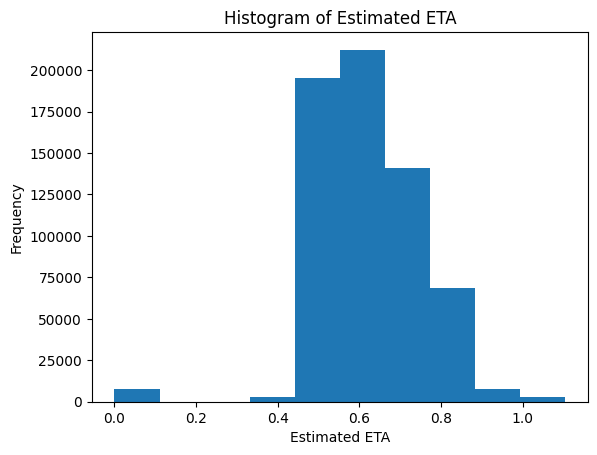

In [17]:
#make a histogram of 'estimated_eta' column
plt.hist(df['estimated_eta'])
plt.xlabel('Estimated ETA')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated ETA')
plt.show()

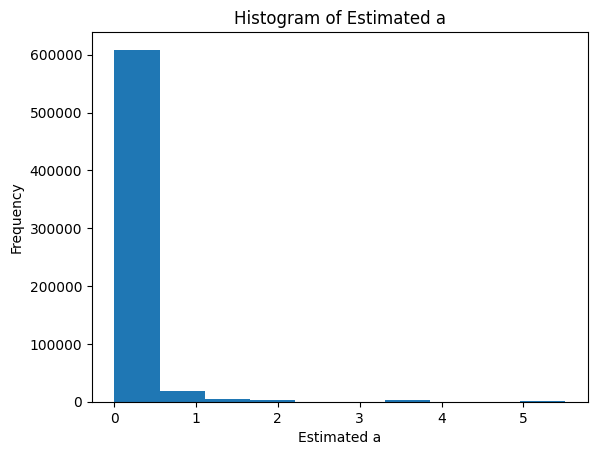

In [18]:
# Make a histogram of 'estimated_a' column
plt.hist(df['estimated_a'])
plt.xlabel('Estimated a')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated a')
plt.show()

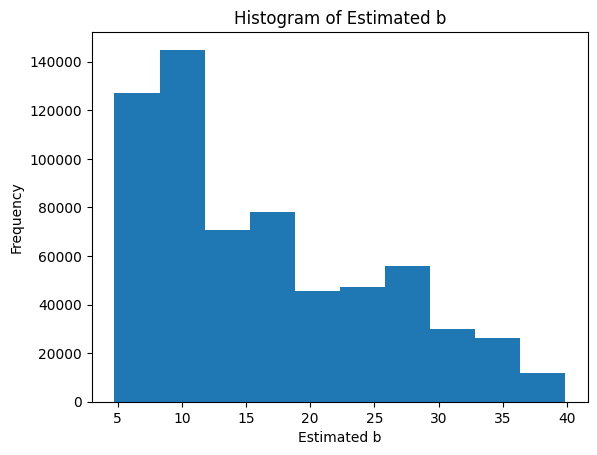

In [19]:
# Make a histogram of 'estimated_b' column
plt.hist(df['estimated_b'])
plt.xlabel('Estimated b')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated b')
plt.show()

In [20]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from preprocess import *

def load_MCMC_df(data=pd.read_csv('Data/base_cleaned.csv')):
    if "Unnamed: 0" in data.columns: 
        data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    if "date_time" in data.columns: 
        data = data.set_index('date_time')
        data = data.sort_index()
    return data

def estimate_demand_parameters(dataframe, price_col='price'):
    """
    Estimates the demand parameters (eta, a, b) using PyMC3 and adds them as new columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data
    :param price_col: Name of the column containing price data
    :return: DataFrame with new columns for eta, a, b estimates
    """
    with pm.Model() as model:
        # Define priors
        # eta에 대한 감마 분포 정의, 평균이 0.4~0.5가 되도록 조정
        eta_shape = 3   # 모양 매개변수
        eta_rate = 6    # 비율 매개변수
        ### Set the prior for eta to be a Gamma distribution with shape=2 and rate=5
        # eta = pm.Gamma('eta', alpha=eta_shape, beta=eta_rate)
        eta = pm.Uniform('eta', lower=0, upper=2)
        ### Set the priors for a and b
        a = pm.Uniform('a', lower=0, upper=10)
        b = pm.Uniform('b', lower=4, upper=70)

        # Convert the price data to a theano tensor
        price_data = tt.as_tensor_variable(dataframe[price_col].values)

        surge_multiplier_data = tt.as_tensor_variable(dataframe['surge_multiplier'].values)
        # Define the demand function using pm.math.exp for exponentiation
        demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b

        # Assuming Gaussian noise in the observed data
        observed = pm.Normal('observed', mu=demand, sd=1, observed=dataframe[price_col])

        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)

    # Extracting the mean of the posterior distributions
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # Adding new columns to the dataframe
    dataframe['estimated_eta'] = eta_mean
    dataframe['estimated_a'] = a_mean
    dataframe['estimated_b'] = b_mean

    return dataframe, trace


def save_demand_data(data=load_MCMC_df()):
    lst_car_type = list(set(data.car_type))
    lst_source = list(set(data.source))
    lst_destination = list(set(data.destination))

    results_list = []

    # 모든 조합에 대해 반복
    for car_type in lst_car_type:
        for source in lst_source:
            for destination in lst_destination:
                # 데이터 필터링
                filtered_data = data[(data['car_type'] == car_type) & (data['source'] == source) & (data['destination'] == destination)]

                # 필터링된 데이터가 비어있지 않은 경우에만 처리
                if not filtered_data.empty:
                    try:
                        # 함수 호출
                        result_df, _ = estimate_demand_parameters(filtered_data, 'price')
                        # 결과 데이터프레임을 리스트에 추가
                        results_list.append(result_df)
                    except Exception as e:
                        print(f"Error processing combination: CarType={car_type}, Source={source}, Destination={destination}")
                        print(f"Error message: {e}")

    # 모든 결과 데이터프레임을 하나로 결합
    combined_df = pd.concat(results_list, ignore_index=True)
    combined_df.to_csv("Data/demand_est_test2.csv", index=False)

In [21]:
save_demand_data()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9058882554008713, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.640204098621309, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/105

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7140231998414591, but should be close to 0.8. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8807798802321672, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9276962359230058, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7077383932454122, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mea

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8956867315079928, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7063831781210433, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8799774983748803, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: Se

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/105095

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7170402753890441, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mea

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.653508696741578, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7153671055088134, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 395 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3509510968153088, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7061308408576414, but should be close to 0.8. Try to increase the number of tuning steps.
There were 365 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44227835462952114, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1530

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164435155411147, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9183923358957495, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5229944402895311, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5900220919935271, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7039506715707973, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6410478174240632, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6248523672351057, but should be close to 0.8. Try to increase the number of tuning steps.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6456333977804971, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 553 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.15401858424344025, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7000359398730907, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 641 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.20767071508543603, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 639 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21174546651348217, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6476686419938054, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6492302749531864, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.688094757850326, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6508645489455879, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 328 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5168834060684071, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6673164812188538, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 300 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49609958260505627, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 331 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5588008271034319, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 366 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2806536649944803, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6163914362833496, but should be close to 0.8. Try to increase the number of tuning steps.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6768255921494111, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1530

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6913732351243518, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7043637127671712, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.879219726355068, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 286 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5399294780710279, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samplin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.642020232111046, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6915832261464147, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7104397464008927, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7072202011883286, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7173329096110308, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8882189858748989, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: Sett

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 332 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4427341895692753, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/10

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7030047971336718, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7121785017486976, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 407 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4610144128835377, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8844262348029606, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8855831844718739, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mea

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7186563781942227, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folde

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 352 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43187241996122955, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5245060784208393, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 484 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28071905621528626, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6452300255532017, but should be close to 0.8. Try to increase the number of tuning steps.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6704716341337222, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6873112756498598, but should be close to 0.8. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7173416018951256, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7107334395629079, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7155847693711549, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8792916481985044, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.889573541316295, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mea

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7121981732799941, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6779467850559724, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6690521375433388, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7166884667144644, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5905014353365475, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6973741874543643, but should be close to 0.8. Try to increase the number of tuning steps.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9218398918442088, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8874326251376121, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6679773727994502, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6876616614256036, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 323 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48523374800705105, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6932328134351101, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7176467583207764, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8843824112108698, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7084761620688832, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8809308623822985, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7167856574937851, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 389 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44789570652168637, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/105095

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7137150902274629, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.588259759177053, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8808071190003641, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.709085068339769, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6786607922566305, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9034302258467498, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mea

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 315 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5269410450964734, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 558 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.24257491663400685, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 286 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5339442681197734, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/10

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7026787980606934, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 535 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29382331991976, but should be close to 0.8. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.666839583856822, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6523147622197993, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 546 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14747446329037595, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6191579296194777, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8961104266417018, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6482867836506203, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8822662813899471, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 708 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.07124074092103305, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_15306/1050958089.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [23]:
df = pd.read_csv('Data/demand_est_test2.csv')

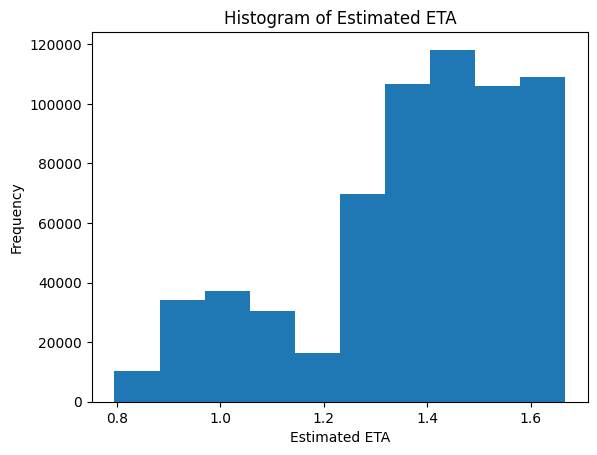

In [24]:
### Make a histogram of 'estimated_eta' column
plt.hist(df['estimated_eta'])
plt.xlabel('Estimated ETA')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated ETA')
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Let's simulate the histogram with two Gaussian components with different heights.
# This means that the weights of the two components in the Gaussian Mixture Model will be different.

# We'll adjust the weights according to the peaks observed in the histogram.
# Assume the first peak has a lower height and therefore a lower weight,
# and the second peak has a higher height and a higher weight.

# For simplicity, we'll keep the means and standard deviations from the previous simulation,
# but adjust the weights.
mean1 = 1.0
std1 = 0.4
mean2 = 1.5
std2 = 0.2
# Adjusted weights for the simulated data
# The first peak seems to have less data, so we'll give it a lower weight
weight1 = 0.3  # 30% of the data in the first Gaussian

# The second peak seems to have more data, so we'll give it a higher weight
weight2 = 0.7  # 70% of the data in the second Gaussian

# Generate the simulated data again with the new weights
data1 = np.random.normal(mean1, std1, int(weight1 * 1000))
data2 = np.random.normal(mean2, std2, int(weight2 * 1000))
simulated_data = np.concatenate([data1, data2])

# Fit a Gaussian Mixture Model again with the new weights
gmm = GaussianMixture(n_components=2, random_state=0, weights_init=[weight1, weight2])
gmm.fit(simulated_data.reshape(-1, 1))

# Predict the labels of the data points again
labels = gmm.predict(simulated_data.reshape(-1, 1))

# Extract the means, covariances, and weights of the two components
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_

# Plot the histogram of the simulated data with the new weights
plt.figure(figsize=(10, 6))
plt.hist(simulated_data, bins=30, alpha=0.5, label='Simulated Data Histogram')

# Plot the Gaussian distributions with the new weights
for mean, covariance, weight in zip(means, covariances, weights):
    pdf = weight * (1 / (np.sqrt(2 * np.pi * covariance))) * np.exp(-0.5 * ((x - mean) ** 2) / covariance)
    plt.plot(x, pdf * 1000, label=f'Gaussian Mean: {mean:.2f}')

# Show the plot
plt.title('Simulated Data with Adjusted Gaussian Mixture Model Fit')
plt.xlabel('Estimated ETA')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Output the parameters of the Gaussian components with new weights
means, np.sqrt(covariances), weights


AttributeError: 'NoneType' object has no attribute 'split'

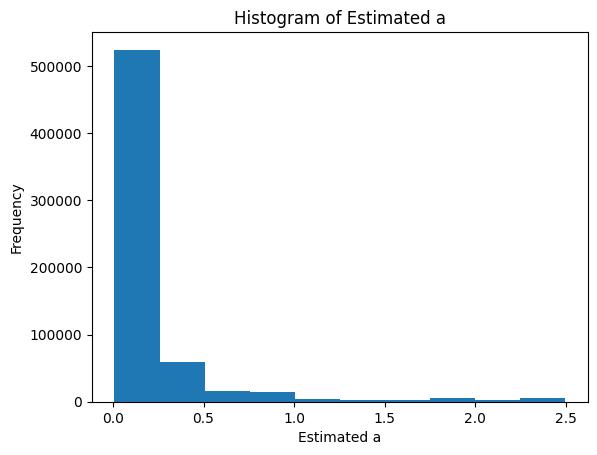

In [25]:
# Make a histogram of 'estimated_a' column
plt.hist(df['estimated_a'])
plt.xlabel('Estimated a')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated a')
plt.show()

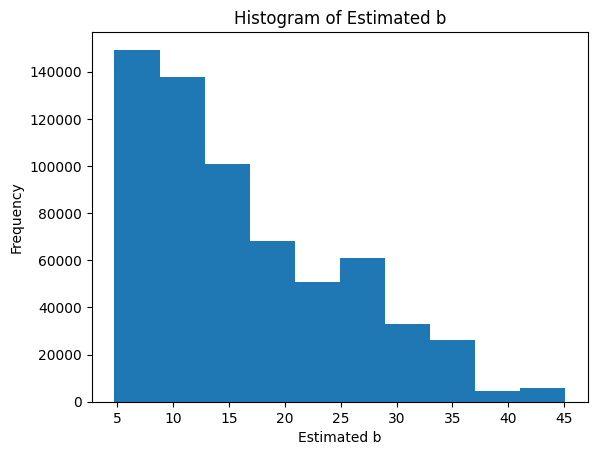

In [26]:
# Make a histogram of 'estimated_b' column
plt.hist(df['estimated_b'])
plt.xlabel('Estimated b')
plt.ylabel('Frequency')
plt.title('Histogram of Estimated b')
plt.show()


In [11]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from preprocess import *

def load_MCMC_df(data=pd.read_csv('Data/base_cleaned.csv')):
    if "Unnamed: 0" in data.columns: 
        data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    if "date_time" in data.columns: 
        data = data.set_index('date_time')
        data = data.sort_index()
    return data

def estimate_demand_parameters(dataframe, price_col='price'):
    """
    Estimates the demand parameters (eta, a, b) using PyMC3 and adds them as new columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data
    :param price_col: Name of the column containing price data
    :return: DataFrame with new columns for eta, a, b estimates
    """
    with pm.Model() as model:
        # Define priors
        # eta에 대한 감마 분포 정의, 평균이 0.4~0.5가 되도록 조정
        eta_shape = 3   # 모양 매개변수
        eta_rate = 6    # 비율 매개변수
        ### Set the prior for eta to be a Gamma distribution with shape=2 and rate=5
        # eta = pm.Gamma('eta', alpha=eta_shape, beta=eta_rate)
        # eta = pm.Uniform('eta', lower=0, upper=2)
        # 첫 번째 가우시안 분포의 추정된 평균과 표준 편차
        mean1 = 1.00
        std1 = 0.08

        # 두 번째 가우시안 분포의 추정된 평균과 표준 편차
        mean2 = 1.40
        std2 = 0.05

        # 두 분포의 추정된 가중치
        weight1 = 0.3
        weight2 = 0.7

        # 각 가우시안 분포의 평균과 역 분산을 정의합니다.
        mu = pm.Normal('mu', mu=[mean1, mean2], sd=1.0, shape=2)  # sd는 임시값으로 설정합니다.
        tau = pm.Gamma('tau', alpha=1.0/std1**2, beta=1.0, shape=2)  # alpha는 임시값으로 설정합니다.

        w = pm.Dirichlet('w', a=np.array([weight1, weight2]))
        
        # 혼합 모델을 정의합니다.
        components = pm.Normal.dist(mu=mu, tau=tau)
        eta = pm.Mixture('y', w=w, comp_dists=components, observed=dataframe[price_col].values)

        ### Set the priors for a and b
        a = pm.Uniform('a', lower=0, upper=10)
        b = pm.Uniform('b', lower=4, upper=70)

        # Convert the price data to a theano tensor
        price_data = tt.as_tensor_variable(dataframe[price_col].values)

        surge_multiplier_data = tt.as_tensor_variable(dataframe['surge_multiplier'].values)
        # Define the demand function using pm.math.exp for exponentiation
        demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b

        # Assuming Gaussian noise in the observed data
        observed = pm.Normal('observed', mu=demand, sd=1, observed=dataframe[price_col])

        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)

    # Extracting the mean of the posterior distributions
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # Adding new columns to the dataframe
    dataframe['estimated_eta'] = eta_mean
    dataframe['estimated_a'] = a_mean
    dataframe['estimated_b'] = b_mean

    return dataframe, trace


def save_demand_data(data=load_MCMC_df()):
    lst_car_type = list(set(data.car_type))
    lst_source = list(set(data.source))
    lst_destination = list(set(data.destination))

    results_list = []

    # 모든 조합에 대해 반복
    for car_type in lst_car_type:
        for source in lst_source:
            for destination in lst_destination:
                # 데이터 필터링
                filtered_data = data[(data['car_type'] == car_type) & (data['source'] == source) & (data['destination'] == destination)]

                # 필터링된 데이터가 비어있지 않은 경우에만 처리
                if not filtered_data.empty:
                    try:
                        # 함수 호출
                        result_df, _ = estimate_demand_parameters(filtered_data, 'price')
                        # 결과 데이터프레임을 리스트에 추가
                        results_list.append(result_df)
                    except Exception as e:
                        print(f"Error processing combination: CarType={car_type}, Source={source}, Destination={destination}")
                        print(f"Error message: {e}")

    # 모든 결과 데이터프레임을 하나로 결합
    combined_df = pd.concat(results_list, ignore_index=True)
    combined_df.to_csv("Data/demand_est_ver4.csv", index=False)

In [12]:
save_demand_data()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/arviz/utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9178059637513412, but should be close to 0.8. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did n

Error processing combination: CarType=Base XL, Source=North Station, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North Station, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North Station, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North Station, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
The acceptance probability does not match the target. It is 0.991495127199513, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9804828164208534, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867600316805785, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North Station, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Base XL, Source=North Station, Destination=Fenway
Error message: Chain 0 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North End, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9809037180899464, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North End, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9991673652802173, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North End, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
The acceptance probability does not match the target. It is 0.9672248236579339, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8831517203407818, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North End, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base XL, Source=North End, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=North End, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Haymarket Square, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.
The acceptance probability does not match the target. It is 0.9899021231682376, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9374080577885342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9927349393065115, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9136614664905528, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Haymarket Square, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Haymarket Square, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
The acceptance probability does not match the target. It is 0.906998065442453, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.891964193677207, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Haymarket Square, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base XL, Source=Haymarket Square, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base XL, Source=Haymarket Square, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Back Bay, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
The acceptance probability does not match the target. It is 0.9217549889548304, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9690478317650772, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.980996362422029, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Back Bay, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.
The acceptance probability does not match the target. It is 0.9718877565153866, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9871877937726438, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Back Bay, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The acceptance probability does not match the target. It is 0.9486262794704212, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Back Bay, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8869442301622291, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Back Bay, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Back Bay, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Base XL, Source=Theatre District, Destination=Boston University
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
The acceptance probability does not match the target. It is 0.9537739411920024, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8974015707535291, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9161190461097385, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Theatre District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.8939639230145483, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Theatre District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9063507356850694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893775183931204, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9186700553297467, but should be close to 0.8. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Theatre District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Base XL, Source=Theatre District, Destination=Northeastern University
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
The acceptance probability does not match the target. It is 0.9298439052183418, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.918961608287699, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9442242759578733, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Theatre District, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9618460382074547, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Beacon Hill, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9778072621432535, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Beacon Hill, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
The acceptance probability does not match the target. It is 0.9072778569660349, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891207788823096, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8891306764658344, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Beacon Hill, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Beacon Hill, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8992508301984312, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9208217921143879, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Beacon Hill, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Beacon Hill, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Base XL, Source=Financial District, Destination=Boston University
Error message: Chain 0 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Financial District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
The acceptance probability does not match the target. It is 0.8842763249723874, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9188885781683773, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Financial District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Financial District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Base XL, Source=Financial District, Destination=Northeastern University
Error message: Chain 2 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9973405590070652, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Financial District, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
The acceptance probability does not match the target. It is 0.9190011910988031, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9167650504937203, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=South Station, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The acceptance probability does not match the target. It is 0.9644878089963326, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9320135090775785, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=South Station, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=South Station, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
The acceptance probability does not match the target. It is 0.9060738051118308, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8808725456608422, but should be close to 0.8. Try to increase the number of tuning steps.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=South Station, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=South Station, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8818550432157847, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=South Station, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9766147666689797, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=West End, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=West End, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The acceptance probability does not match the target. It is 0.8793423196737314, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=West End, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9280587759688234, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=West End, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=West End, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=West End, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9949550264651595, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9918997889425737, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Boston University, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8831526287483618, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Boston University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
The acceptance probability does not match the target. It is 0.8886081591923883, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9942996725257577, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8894282467952055, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Boston University, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9704131590550776, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8837633689675033, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Boston University, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
The acceptance probability does not match the target. It is 0.9546998863938729, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9773165264012635, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918358857628513, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9872573411075943, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Boston University, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9311180132740505, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8851518443492931, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Boston University, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8999384184047635, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Fenway, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9725444975270308, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Fenway, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
The acceptance probability does not match the target. It is 0.9712541954876679, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9489208152447124, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8805759916802569, but should be close to 0.8. Try to increase the number of tuning steps.


Error processing combination: CarType=Base XL, Source=Fenway, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
The acceptance probability does not match the target. It is 0.9571813781480348, but should be close to 0.8. Try to increase the number of tuning steps.


Error processing combination: CarType=Base XL, Source=Fenway, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base XL, Source=Fenway, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8932102477368743, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9557150036555961, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Fenway, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
The acceptance probability does not match the target. It is 0.881597166900565, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8995478718591041, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Northeastern University, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Northeastern University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Northeastern University, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base XL, Source=Northeastern University, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Base XL, Source=Northeastern University, Destination=Financial District
Error message: Chain 0 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Base XL, Source=Northeastern University, Destination=West End
Error message: Chain 2 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=North Station, Destination=Boston University
Error message: Chain 0 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=North Station, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=North Station, Destination=Haymarket Square
Error message: Chain 2 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=North Station, Destination=South Station
Error message: Chain 3 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=North Station, Destination=Northeastern University
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=North Station, Destination=Fenway
Error message: Chain 0 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=North End, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=North End, Destination=Back Bay
Error message: Chain 2 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=North End, Destination=Theatre District
Error message: Chain 2 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
The acceptance probability does not match the target. It is 0.9550623165044952, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9906353869856122, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.99763947887306, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=North End, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=North End, Destination=Financial District
Error message: Chain 3 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 126 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.895018713508159, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9963017761039066, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=North End, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
The acceptance probability does not match the target. It is 0.928450775129742, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823642258498267, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9292501943351721, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=Back Bay
Error message: Chain 0 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=Theatre District
Error message: Chain 2 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=Beacon Hill
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=Financial District
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
The acceptance probability does not match the target. It is 0.8919883556939376, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8814924543983, but should be close to 0.8. Try to increase the number of tuning steps.


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=North End
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=Haymarket Square
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=South Station
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=Northeastern University
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9639833564904714, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9286974404836592, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8971198842847382, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=Boston University
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=North End
Error message: Chain 3 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=Haymarket Square
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9338298107702071, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=Northeastern University
Error message: Chain 2 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=Fenway
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=Boston University
Error message: Chain 2 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=North End
Error message: Chain 3 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=Haymarket Square
Error message: Chain 0 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=South Station
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=Northeastern University
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
The acceptance probability does not match the target. It is 0.950691128407148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9356502279916802, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9965465004276964, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9323596558066033, but should be close to 0.8. Try to increase the number of tuning steps.


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Financial District, Destination=Boston University
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.890431041655069, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.995346401725355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836024771229171, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.986225429004149, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Financial District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.
The acceptance probability does not match the target. It is 0.9519545941534977, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853498747497223, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9595061454565331, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9847448651695109, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Financial District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.878938844756135, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012975712201969, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790395517602435, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Financial District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Financial District, Destination=Northeastern University
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Financial District, Destination=Fenway
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=South Station, Destination=North Station
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=South Station, Destination=Back Bay
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=South Station, Destination=Theatre District
Error message: Chain 1 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
The acceptance probability does not match the target. It is 0.9101387359764627, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9037943611043031, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9498388123275204, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=South Station, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
The acceptance probability does not match the target. It is 0.9773859065071538, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9299410717547288, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=South Station, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=South Station, Destination=West End
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=West End, Destination=Boston University
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=West End, Destination=North End
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9892354293198885, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=West End, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 139 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9829741502969912, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9993170138982758, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9915906208172479, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=West End, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=West End, Destination=Northeastern University
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=West End, Destination=Fenway
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Boston University, Destination=North Station
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
The acceptance probability does not match the target. It is 0.9230864695591667, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952625135910811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9686990202758105, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Boston University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Boston University, Destination=Theatre District
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Boston University, Destination=Beacon Hill
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Boston University, Destination=Financial District
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Boston University, Destination=West End
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Fenway, Destination=North Station
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
The acceptance probability does not match the target. It is 0.8882387503746336, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9905052443760571, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887083726125725, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.942624755206921, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Fenway, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Fenway, Destination=Theatre District
Error message: Chain 1 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
The acceptance probability does not match the target. It is 0.9786727990313251, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9240272614954563, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8981838918283059, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury, Source=Fenway, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Fenway, Destination=Financial District
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Fenway, Destination=West End
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=North Station
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 137 seconds.
The acceptance probability does not match the target. It is 0.9931926540198042, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9992333531163262, but should be close to 0.8. Try to increase the number of tuning steps.


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=Theatre District
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=Beacon Hill
Error message: Chain 2 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=Financial District
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=West End
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the ab

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
There were 866 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 8.787871164657496e-05, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.08812609150615275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818347815326226, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.968070695765149, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of eff

Error processing combination: CarType=Shared, Source=North Station, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
The acceptance probability does not match the target. It is 0.9417249969445995, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North Station, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North Station, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North Station, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 661 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.004746081432739081, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892640180889659, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North Station, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The acceptance probability does not match the target. It is 0.8802806469032223, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North Station, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9116020440651191, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8989187271907094, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North End, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 9.025813248674743e-40, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9526635123737872, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9343222970899184, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North End, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
The acceptance probability does not match the target. It is 0.9121886659694377, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 1.7291440911148442e-204, but should be close to 0.8. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North End, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
The acceptance probability does not match the target. It is 0.967507261986192, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North End, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.25933918283758634, but should be close to 0.8. Try to increase the number of tuning steps.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North End, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The acceptance probability does not match the target. It is 6.42715447827105e-296, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9592217556662757, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9002034332667807, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=North End, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Haymarket Square, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
The acceptance probability does not match the target. It is 0.9731901812362054, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Haymarket Square, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
The acceptance probability does not match the target. It is 0.985743815588387, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Haymarket Square, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Haymarket Square, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Haymarket Square, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Haymarket Square, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.97065603869192, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Back Bay, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Back Bay, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
The acceptance probability does not match the target. It is 0.8894425564578444, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9759984725209694, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Back Bay, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
The acceptance probability does not match the target. It is 0.8926576145183165, but should be close to 0.8. Try to increase the number of tuning steps.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9143816752528237, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Back Bay, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9471217847839991, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Back Bay, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Back Bay, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
The acceptance probability does not match the target. It is 0.9348585437689355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018158182782915, but should be close to 0.8. Try to increase the number of tuning steps.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Theatre District, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The acceptance probability does not match the target. It is 0.9582162262390761, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Theatre District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Theatre District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
The acceptance probability does not match the target. It is 0.8941851766022956, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Theatre District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 999 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 2.964961921652602e-109, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9849209775080277, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Theatre District, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9058427689837613, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Theatre District, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.9063078224775379, but should be close to 0.8. Try to increase the number of tuning steps.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5279901815660223, but should be close to 0.8. Try to increase the number of tuning steps.
There were 659 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0012140432767702037, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Beacon Hill, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8866774928107111, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Beacon Hill, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47332237531139654, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.999071828818302, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Beacon Hill, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Beacon Hill, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
The acceptance probability does not match the target. It is 0.9681868656350935, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9057609966590178, but should be close to 0.8. Try to increase the number of tuning steps.
There were 629 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.003058280473457295, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Beacon Hill, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Beacon Hill, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
The acceptance probability does not match the target. It is 0.9020571082691852, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Financial District, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Financial District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6383749664776288, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Financial District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Financial District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Shared, Source=Financial District, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8845439629939343, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9668611378268642, but should be close to 0.8. Try to increase the number of tuning steps.
There were 575 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0036935191962153926, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Financial District, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=South Station, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


Error processing combination: CarType=Shared, Source=South Station, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The acceptance probability does not match the target. It is 0.9832266189608264, but should be close to 0.8. Try to increase the number of tuning steps.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=South Station, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=South Station, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8864640811793142, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=South Station, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9956930390218591, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=South Station, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=West End, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The acceptance probability does not match the target. It is 0.9980923470692141, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=West End, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=West End, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
The acceptance probability does not match the target. It is 0.9053976324829107, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=West End, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The acceptance probability does not match the target. It is 0.9743375496124229, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9070197738671234, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=West End, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.001, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.910769771251704, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=West End, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Boston University, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
The acceptance probability does not match the target. It is 0.8922722862050589, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Boston University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9063608515231373, but should be close to 0.8. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Boston University, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 382 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.3725912069824342e-20, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Boston University, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The acceptance probability does not match the target. It is 0.9900259210960911, but should be close to 0.8. Try to increase the number of tuning steps.


Error processing combination: CarType=Shared, Source=Boston University, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
The acceptance probability does not match the target. It is 0.9215042799995561, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9731581950505392, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Boston University, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
The acceptance probability does not match the target. It is 0.9743163601028142, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Fenway, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Fenway, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The acceptance probability does not match the target. It is 0.8844101268608912, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Fenway, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
There were 996 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.7336334076499333e-77, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9037374133642532, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9947480285882266, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Fenway, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 435 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4310999895983726, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9709945412278237, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Fenway, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The acceptance probability does not match the target. It is 0.9361831458132465, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Fenway, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
The acceptance probability does not match the target. It is 0.9853679417873714, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8872025785865882, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9058976792765318, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
The acceptance probability does not match the target. It is 0.9015165793374037, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9925039542872317, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9020488300985501, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891304544481007, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North Station, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North Station, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North Station, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North Station, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North Station, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North Station, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North End, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8991056390295898, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North End, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base, Source=North End, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North End, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=North End, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base, Source=North End, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8863322281358549, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Haymarket Square, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Haymarket Square, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5960636263285871, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Haymarket Square, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Haymarket Square, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Haymarket Square, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Haymarket Square, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Back Bay, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Back Bay, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7037106080086923, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Back Bay, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Back Bay, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base, Source=Back Bay, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Back Bay, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Theatre District, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Theatre District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Theatre District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Theatre District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Theatre District, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base, Source=Theatre District, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Beacon Hill, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Beacon Hill, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Beacon Hill, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Beacon Hill, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Beacon Hill, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Beacon Hill, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Financial District, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Financial District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Financial District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Financial District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9347469959143615, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Financial District, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Financial District, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=South Station, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8905927020603595, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=South Station, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=South Station, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=South Station, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=South Station, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=South Station, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.883660344098597, but should be close to 0.8. Try to increase the number of tuning steps.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7119356281122802, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=West End, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=West End, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=West End, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=West End, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=West End, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=West End, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Boston University, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base, Source=Boston University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Boston University, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Boston University, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8897562800473763, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Boston University, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Boston University, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Fenway, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7175632255201911, but should be close to 0.8. Try to increase the number of tuning steps.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base, Source=Fenway, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base, Source=Fenway, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Fenway, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
The acceptance probability does not match the target. It is 0.9179991105844478, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Fenway, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Fenway, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Base, Source=Northeastern University, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Northeastern University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8865353247537372, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Northeastern University, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8791236036599981, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Northeastern University, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 113 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9909123851016121, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Northeastern University, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Base, Source=Northeastern University, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North Station, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North Station, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North Station, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North Station, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North Station, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=North Station, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
The acceptance probability does not match the target. It is 0.880277446076525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=North End, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North End, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The acceptance probability does not match the target. It is 0.8911113243005994, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North End, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North End, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North End, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The acceptance probability does not match the target. It is 0.8948238400000218, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=North End, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Haymarket Square, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Haymarket Square, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Haymarket Square, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Haymarket Square, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7083929434887973, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Haymarket Square, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=Haymarket Square, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Back Bay, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Back Bay, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7169610784907068, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=Back Bay, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Back Bay, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Back Bay, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Back Bay, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Theatre District, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Theatre District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Theatre District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Theatre District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Theatre District, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Theatre District, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=Beacon Hill, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Beacon Hill, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Beacon Hill, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Beacon Hill, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Beacon Hill, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Beacon Hill, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Financial District, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Financial District, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Financial District, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Financial District, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Financial District, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
The acceptance probability does not match the target. It is 0.8865560032192495, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Financial District, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=South Station, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=South Station, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=South Station, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=South Station, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=South Station, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=South Station, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=West End, Destination=Boston University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=West End, Destination=North End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=West End, Destination=Haymarket Square
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=West End, Destination=South Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=West End, Destination=Northeastern University
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=West End, Destination=Fenway
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Boston University, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Boston University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Boston University, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Boston University, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Error processing combination: CarType=Wheel Chair Accessible, Source=Boston University, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Boston University, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Fenway, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Fenway, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Fenway, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Fenway, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Fenway, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Fenway, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Northeastern University, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Northeastern University, Destination=Back Bay
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Northeastern University, Destination=Theatre District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Northeastern University, Destination=Beacon Hill
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Northeastern University, Destination=Financial District
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Wheel Chair Accessible, Source=Northeastern University, Destination=West End
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North Station, Destination=Boston University
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North Station, Destination=North End
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North Station, Destination=Haymarket Square
Error message: Chain 3 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North Station, Destination=South Station
Error message: Chain 2 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North Station, Destination=Northeastern University
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North Station, Destination=Fenway
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.
The acceptance probability does not match the target. It is 0.9957245880062917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9671305258290225, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9611118008558217, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Error processing combination: CarType=Luxury SUV, Source=North End, Destination=North Station
Error message: 'Unknown variable eta'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encounte

Error processing combination: CarType=Luxury SUV, Source=North End, Destination=Back Bay
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North End, Destination=Theatre District
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North End, Destination=Beacon Hill
Error message: Chain 1 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North End, Destination=Financial District
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=North End, Destination=West End
Error message: Chain 3 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Haymarket Square, Destination=North Station
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Haymarket Square, Destination=Back Bay
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Haymarket Square, Destination=Theatre District
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Haymarket Square, Destination=Beacon Hill
Error message: Chain 1 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Haymarket Square, Destination=Financial District
Error message: Chain 1 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Haymarket Square, Destination=West End
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=Boston University
Error message: Chain 2 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=North End
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=Haymarket Square
Error message: Chain 1 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=South Station
Error message: Chain 1 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=Northeastern University
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Back Bay, Destination=Fenway
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Theatre District, Destination=Boston University
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Theatre District, Destination=North End
Error message: Chain 0 failed.


Process worker_chain_2:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Theatre District, Destination=Haymarket Square
Error message: Chain 3 failed.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, w, tau, mu]


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


Error processing combination: CarType=Luxury SUV, Source=Theatre District, Destination=South Station
Error message: Chain 0 failed.


Process worker_chain_3:
Traceback (most recent call last):
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 137, in run
    self._start_loop()
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/parallel_sampling.py", line 209, in _start_loop
    self._msg_pipe.send(("writing_done", is_last, draw, tuning, stats, warns))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last

/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


In [13]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from preprocess import *

def load_MCMC_df(data = get_cleaned_data()):
    if "Unnamed: 0" in data.columns: 
        data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    if "date_time" in data.columns: 
        data = data.set_index('date_time')
        data = data.sort_index()      
    return data


def estimate_demand_parameters(dataframe, price_col):
    """
    Estimates the demand parameters (eta, a, b) using PyMC3 and adds them as new columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data
    :param price_col: Name of the column containing price data
    :return: DataFrame with new columns for eta, a, b estimates
    """
    with pm.Model() as model:
        # Define priors
        eta_shape = 2
        eta_rate = 5

        ### Set the prior for eta to be a Gamma distribution with shape=2 and rate=5
        eta = pm.Gamma('eta', alpha=eta_shape, beta=eta_rate)

        ### Set the priors for a and b
        a = pm.Uniform('a', lower=0, upper=10)
        b = pm.Uniform('b', lower=4, upper=70)

        # Convert the price data to a theano tensor
        price_data = tt.as_tensor_variable(dataframe[price_col].values)

        surge_multiplier_data = tt.as_tensor_variable(dataframe['surge_multiplier'].values)
        # Define the demand function using pm.math.exp for exponentiation
        demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b

        # Assuming Gaussian noise in the observed data
        observed = pm.Normal('observed', mu=demand, sd=1, observed=dataframe[price_col])

        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)

    # Extracting the mean of the posterior distributions
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # Adding new columns to the dataframe
    dataframe['estimated_eta'] = eta_mean
    dataframe['estimated_a'] = a_mean
    dataframe['estimated_b'] = b_mean

    return dataframe, trace


def save_demand_data(data=load_MCMC_df()):
    lst_car_type = list(set(data.car_type))
    lst_source = list(set(data.source))
    lst_destination = list(set(data.destination))

    results_list = []

    # Iterate through all combinations of car_type, source, and destination
    for car_type in lst_car_type:
        for source in lst_source:
            for destination in lst_destination:
                # Filter the data for the current combination
                filtered_data = data[(data['car_type'] == car_type) & (data['source'] == source) & (data['destination'] == destination)]

                # If the filtered data is not empty, estimate the demand parameters
                if not filtered_data.empty:
                    try:
                        # Estimate the demand parameters and add them to the dataframe
                        result_df, _ = estimate_demand_parameters(filtered_data, 'price')
                        results_list.append(result_df)
                    except Exception as e:
                        print(f"Error processing combination: CarType={car_type}, Source={source}, Destination={destination}")
                        print(f"Error message: {e}")

    # Combine all the results into a single dataframe
    combined_df = pd.concat(results_list, ignore_index=False)
    combined_df.to_csv("Data/demand_est_test.csv", index=True)

In [14]:
save_demand_data()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6996290297856875, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 579 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3221590411331003, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5919739763046057, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7111278450102037, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7195258777015648, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6578294452684129, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6670637275735724, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7044079148263528, but should be close to 0.8. Try to increase the number of tuning steps.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7210822797049038, but should be close to 0.8. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6447297267993773, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6780549379411259, but should be close to 0.8. Try to increase the number of tuning steps.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5946535646945069, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6077585804375382, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7115144109612176, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.576765299167811, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5963208423436176, but should be close to 0.8. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7154370589395432, but should be close to 0.8. Try to increase the number of tuning steps.
There were 590 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1151702533197005, but should be close to 0.8. Try to increase the number of tuning steps.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.624046514104314, but should be close to 0.8. Try to increase the number of tuning steps.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050134955009105, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7049896988955309, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6790179692450458, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.718559905519611, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7046549292510597, but should be close to 0.8. Try to increase the number of tuning steps.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6945524290167423, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6687768363449533, but should be close to 0.8. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6603271311369495, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_2644

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.72106665260981, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6389329859502966, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.681749777139183, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.688060409192356, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7118675250692776, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 507 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19690404184825955, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6658185777552206, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7120520123440305, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6735676213763675, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5831187776984038, but should be close to 0.8. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7060557249604987, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6899473468902352, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6789683952080654, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6024950714525873, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 310 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5636096347445186, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.541824586959613, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 366 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5113113827040536, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 346 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4803096464797133, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5939062019842747, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8895014878038905, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7001317360356322, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6781640584716108, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 606 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.22344394159395958, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6995901089687759, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7016715997123801, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.694449061035162, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7213350425459114, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6833024575687061, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6831409553144814, but should be close to 0.8. Try to increase the number of tuning steps.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6828170471967128, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6717178579037344, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 341 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5087170747466774, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7196085844612645, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8820721476275363, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7113635275982404, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 429 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3961947620830622, but should be close to 0.8. Try to increase the number of tuning steps.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7075924822592959, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7210095401113972, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.716986247212846, but should be close to 0.8. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 309 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5290742226635393, but should be close to 0.8. Try to increase the number of tuning steps.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6380406500438135, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6769619706401131, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7125336580743041, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 795 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.050976762030640804, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7207804735483658, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6683455373226687, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6752597351741216, but should be close to 0.8. Try to increase the number of tuning steps.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6948683771007919, but should be close to 0.8. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6967496586110931, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7126423275971647, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6254784336850084, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6697803676260996, but should be close to 0.8. Try to increase the number of tuning steps.
There were 429 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3991124375314504, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7031146701362594, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6824525668897755, but should be close to 0.8. Try to increase the number of tuning steps.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.626943027995294, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6579603156861589, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6436616458468077, but should be close to 0.8. Try to increase the number of tuning steps.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6476410714737416, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6414062458871647, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6870378386541345, but should be close to 0.8. Try to increase the number of tuning steps.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.679821293780185, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7063405390098076, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6725919453179627, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7194573598908682, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.382908238401719, but should be close to 0.8. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7188946994003884, but should be close to 0.8. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164275535476313, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samplin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 303 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45979488346874803, but should be close to 0.8. Try to increase the number of tuning steps.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6477488760022408, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5643790780858429, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6913747509734365, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7211923930962032, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7080468163139676, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7115629378302071, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7210874747501168, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6450093287924057, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7090365394854887, but should be close to 0.8. Try to increase the number of tuning steps.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40450479991418103, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7168160011605386, but should be close to 0.8. Try to increase the number of tuning steps.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5275744896789675, but should be close to 0.8. Try to increase the number of tuning steps.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7091396440529427, but should be close to 0.8. Try to increase the number of tuning steps.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46595590179755686, but should be close t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7203550012274443, but should be close to 0.8. Try to increase the number of tuning steps.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4894029956153774, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6968409266748675, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 368 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4571433319829613, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.700808092616287, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6139044513062468, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.581533574425978, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6917713860541193, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6941402291613689, but should be close to 0.8. Try to increase the number of tuning steps.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 220 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6524749146023633, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6828457324317756, but should be close to 0.8. Try to increase the number of tuning steps.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5901942781729674, but should be close to 0.8. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_2644

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 362 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35267561606260633, but should be close to 0.8. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6293108703377227, but should be close to 0.8. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6808746436306027, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sam

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 270 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5413089974855774, but should be close to 0.8. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 257 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.556313746570136, but should be close to 0.8. Try to increase the number of tuning steps.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7129257213100948, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samp

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5602002413663058, but should be close to 0.8. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6769529781255023, but should be close to 0.8. Try to increase the number of tuning steps.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6788402924540268, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6504718578061442, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7119027186120451, but should be close to 0.8. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6891880433092524, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_2644

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7158148122942085, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.700270862095359, but should be close to 0.8. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6917138317671508, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6492415421072119, but should be close to 0.8. Try to increase the number of tuning steps.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.712539852551971, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5858155301574136, but should be close to 0.8. Try to increase the number of tuning steps.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6132774566953298, but should be close to 0.8. Try to increase the number of tuning steps.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6909117755955972, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sam

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6125364262144373, but should be close to 0.8. Try to increase the number of tuning steps.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6821858201656562, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6294766814993017, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_2644

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6892505091626169, but should be close to 0.8. Try to increase the number of tuning steps.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7030850998691371, but should be close to 0.8. Try to increase the number of tuning steps.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7154676028115641, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7190287179046356, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7033284304791895, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6983569355794402, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7107138011643397, but should be close to 0.8. Try to increase the number of tuning steps.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7065243925311977, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6957995234599896, but should be close to 0.8. Try to increase the number of tuning steps.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6906043081338574, but should be close to 0.8. Try to increase the number of tuning steps.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 286 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5536312132942387, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6444020631827011, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7168592481690621, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6362465752044872, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.698027104238499, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5369354518460265, but should be close to 0.8. Try to increase the number of tuning steps.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6201969637289387, but should be close to 0.8. Try to increase the number of tuning steps.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6795250365642544, but should be close to 0.8. Try to increase the number of tuning steps.
There were 696 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1234476353955205, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimate

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7055742945805417, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6660733513204743, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_264

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6996755374643523, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 186 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6782057723133754, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49451154732037605, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_264

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.704001211075662, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6889534655269365, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 169 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6879802891964525, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7028626451290967, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.700303608839943, but should be close to 0.8. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 316 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5635732781154632, but should be close to 0.8. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6884413472843394, but should be close to 0.8. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6650689791057084, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7134324875396945, but should be close to 0.8. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6656649226018296, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6681412428883111, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.64283477422492, but should be close to 0.8. Try to increase the number of tuning steps.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6348048484369958, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6857600459496502, but should be close to 0.8. Try to increase the number of tuning steps.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6719865987510208, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 297 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5463298364143732, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6585690128977149, but should be close to 0.8. Try to increase the number of tuning steps.
There were 198 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6634831049257229, but should be close to 0.8. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088475834962074, but should be close to 0.8. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6661233818185078, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/35974278

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6946281201343372, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_264

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7176738538340846, but should be close to 0.8. Try to increase the number of tuning steps.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6524657913902641, but should be close to 0.8. Try to increase the number of tuning steps.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6244368228366681, but should be close to 0.8. Try to increase the number of tuning steps.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050698369152489, but should be close to 0.8. Try to increase the number of tuning steps.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6935405580523125, but should be close to 0.8. Try to increase the number of tuning steps.
There were 316 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5458620951670898, but should be close to 0.8. Try to increase the number of tuning steps.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6643320932102249, but should be close to 0.8. Try to increase the number of tuning steps.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.649774462860781, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6890806598191388, but should be close to 0.8. Try to increase the number of tuning steps.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6292557829146237, but should be close to 0.8. Try to increase the number of tuning steps.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6590204903249343, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6436158253483935, but should be close to 0.8. Try to increase the number of tuning steps.
There were 320 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5128931093157767, but should be close to 0.8. Try to increase the number of tuning steps.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_264

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6120996186159237, but should be close to 0.8. Try to increase the number of tuning steps.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 230 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5533515148261761, but should be close to 0.8. Try to increase the number of tuning steps.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6886143775070498, but should be close to 0.8. Try to increase the number of tuning steps.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_2644

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164454838222779, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7154578958054417, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7146514952451815, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7134816376755532, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 272 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4639985694794361, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7040278579051414, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6758033268422623, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6396091108941234, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6569154271970219, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7025287734466054, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5840680053826288, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7209104996723361, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6144031764852, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6912282383074212, but should be close to 0.8. Try to increase the number of tuning steps.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6387655755848229, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5664740262710418, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6882940172371314, but should be close to 0.8. Try to increase the number of tuning steps.
There were 282 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5212641600929275, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.713028224737813, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.6967489382809313e-05, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7095386428466844, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7036207760746109, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4905475260002788, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7146484911833618, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7186300529403548, but should be close to 0.8. Try to increase the number of tuning steps.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6517782729970668, but should be close to 0.8. Try to increase the number of tuning steps.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5272525640562451, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samp

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.716365397272703, but should be close to 0.8. Try to increase the number of tuning steps.
There were 794 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1642493037151546, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6157550449131479, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6898589627831975, but should be close to 0.8. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7054334507597562, but should be close to 0.8. Try to increase the number of tuning steps.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6811420849947938, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7117269110629252, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6797060613462031, but should be close to 0.8. Try to increase the number of tuning steps.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6977584288966131, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.692213019527576, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7021389514369949, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6443809240536276, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.706525727600965, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5729606555512786, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6898668466475743, but should be close to 0.8. Try to increase the number of tuning steps.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6463556229026935, but should be close to 0.8. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6337064477594415, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samp

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7148813721007863, but should be close to 0.8. Try to increase the number of tuning steps.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7128766949306332, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7202183689267511, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6785244785478062, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7157531979929386, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 519 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19428982016278312, but should be close to 0.8. Try to increase the number of tuning steps.
There were 273 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.587021480397929, but should be close to 0.8. Try to increase the number of tuning steps.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6320678837431324, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7185139951754792, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7134206069444572, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215964695515609, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7087627492543667, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7022214289294635, but should be close to 0.8. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7130536469558325, but should be close to 0.8. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6028419434832244, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7172884287078898, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.715544239741655, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6298074937900472, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5927550721869255, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6405679773572988, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6658160041040048, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6946730872708529, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7165264808315076, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44625698438858596, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_264

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 389 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49211142768352895, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5768177558767906, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 431 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3168003987705839, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5806913587967711, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 253 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5756335208796667, but should be close to 0.8. Try to increase the number of tuning steps.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6468592918031932, but should be close to 0.8. Try to increase the number of tuning steps.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_264

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5664051580404846, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5918451105617142, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_2644

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 517 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1947464977722856, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 211 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6113209420434159, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6228546839559328, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6924332891109145, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_2644

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6981081039053892, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.604247639923363, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7020978827219826, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6688695977169844, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7113104798313459, but should be close to 0.8. Try to increase the number of tuning steps.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7102436397864637, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_2644

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6453017207544955, but should be close to 0.8. Try to increase the number of tuning steps.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7160490226515497, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6735410409528632, but should be close to 0.8. Try to increase the number of tuning steps.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6404504721373624, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7165513105809914, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5989777632294879, but should be close to 0.8. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5769981829278692, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7053031678468096, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6744116048456926, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 263 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.512939543135465, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_26441/3597427848.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [ ]:
df3 = pd.read_csv('Data/demand_est_test.csv')
df3.head()

In [6]:
df = get_cleaned_data()
df.head()

date_time  distance cab_type                   source  \
0 2018-11-26 03:40:46.318      3.03     Lyft        Boston University   
1 2018-11-26 03:40:46.319      1.30     Uber            South Station   
2 2018-11-26 03:40:46.320      2.43     Lyft  Northeastern University   
3 2018-11-26 03:40:46.320      2.71     Uber         Theatre District   
4 2018-11-26 03:40:46.320      2.71     Uber         Theatre District   

        destination    car_type  weekday  rush_hour  is_raining  temp_groups  \
0  Theatre District  Luxury SUV        1          0           0           40   
1  Theatre District      Luxury        1          0           0           40   
2       Beacon Hill        Base        1          0           0           40   
3            Fenway     Base XL        1          0           0           40   
4            Fenway        Base        1          0           0           40   

   surge_multiplier  price  
0               1.0   34.0  
1               1.0   18.5  
2               1.0   10.5  
3               1.0   32.0  
4               1.0   19.5

In [7]:
df_sample = df.sample(300)
df_sample.shape

(300, 12)

In [8]:
df_sample.to_csv("Data/demand_est_sample.csv", index=True)

In [10]:
df2 = pd.read_csv('Data/demand_est_sample.csv')
df2.head()

Unnamed: 0                date_time  distance cab_type             source  \
0      566187  2018-12-17 01:40:10.126      1.36     Uber        Beacon Hill   
1       63233  2018-11-27 11:30:22.255      0.55     Uber   Theatre District   
2      562224  2018-12-16 23:20:09.254      3.39     Uber  Boston University   
3      152530  2018-11-28 20:32:07.951      1.82     Uber             Fenway   
4      355420  2018-12-03 05:02:59.647      1.41     Uber          North End   

        destination    car_type  weekday  rush_hour  is_raining  temp_groups  \
0  Haymarket Square  Luxury SUV        1          0           1           40   
1     South Station  Luxury SUV        1          0           0           40   
2     North Station     Base XL        0          0           1           40   
3          Back Bay        Base        1          0           0           40   
4  Theatre District  Luxury SUV        1          0           0           40   

   surge_multiplier  price  
0               1.0   26.0  
1               1.0   27.5  
2               1.0   24.0  
3               1.0    9.5  
4               1.0   27.5

In [16]:
import pandas as pd
df = pd.read_csv('Data/demand_est_last.csv')
df.head()

date_time  distance cab_type              source  \
0  2018-11-26 04:41:37.193      0.52     Lyft  Financial District   
1  2018-11-26 04:41:37.422      0.39     Uber  Financial District   
2  2018-11-26 05:28:07.500      0.39     Uber  Financial District   
3  2018-11-26 06:14:16.086      0.48     Lyft  Financial District   
4  2018-11-26 06:23:02.642      0.39     Uber  Financial District   

     destination car_type  weekday  rush_hour  is_raining  temp_groups  \
0  South Station  Base XL        1          0           0           40   
1  South Station  Base XL        1          0           0           40   
2  South Station  Base XL        1          0           0           40   
3  South Station  Base XL        1          0           0           40   
4  South Station  Base XL        1          0           0           40   

   surge_multiplier  price  estimated_eta  estimated_a  estimated_b  
0              1.00    9.0       0.400576     0.052083     9.459884  
1              1.00   10.5       0.400576     0.052083     9.459884  
2              1.00    9.5       0.400576     0.052083     9.459884  
3              1.75   13.5       0.400576     0.052083     9.459884  
4              1.00    9.5       0.400576     0.052083     9.459884

In [1]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from preprocess import *

def load_MCMC_df(data = get_cleaned_data()):
    if "Unnamed: 0" in data.columns: 
        data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    if "date_time" in data.columns: 
        data = data.set_index('date_time')
        data = data.sort_index()      
    return data


def estimate_demand_parameters(dataframe, price_col):
    """
    Estimates the demand parameters (eta, a, b) using PyMC3 and adds them as new columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data
    :param price_col: Name of the column containing price data
    :return: DataFrame with new columns for eta, a, b estimates
    """
    with pm.Model() as model:
        # Define priors
        eta_shape = 2
        eta_rate = 5

        ### Set the prior for eta to be a Gamma distribution with shape=2 and rate=5
        eta = pm.Gamma('eta', alpha=eta_shape, beta=eta_rate)

        ### Set the priors for a and b
        a = pm.Uniform('a', lower=0, upper=100)
        b = pm.Uniform('b', lower=0, upper=20)

        # Convert the price data to a theano tensor
        price_data = tt.as_tensor_variable(dataframe[price_col].values)

        surge_multiplier_data = tt.as_tensor_variable(dataframe['surge_multiplier'].values)
        # Define the demand function using pm.math.exp for exponentiation
        demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b

        # Assuming Gaussian noise in the observed data
        observed = pm.Normal('observed', mu=demand, sd=1, observed=dataframe[price_col])

        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)

    # Extracting the mean of the posterior distributions
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # Adding new columns to the dataframe
    dataframe['estimated_eta'] = eta_mean
    dataframe['estimated_a'] = a_mean
    dataframe['estimated_b'] = b_mean

    return dataframe, trace


def save_demand_data(data=load_MCMC_df()):
    lst_car_type = list(set(data.car_type))
    lst_source = list(set(data.source))
    lst_destination = list(set(data.destination))

    results_list = []

    # Iterate through all combinations of car_type, source, and destination
    for car_type in lst_car_type:
        for source in lst_source:
            for destination in lst_destination:
                # Filter the data for the current combination
                filtered_data = data[(data['car_type'] == car_type) & (data['source'] == source) & (data['destination'] == destination)]

                # If the filtered data is not empty, estimate the demand parameters
                if not filtered_data.empty:
                    try:
                        # Estimate the demand parameters and add them to the dataframe
                        result_df, _ = estimate_demand_parameters(filtered_data, 'price')
                        results_list.append(result_df)
                    except Exception as e:
                        print(f"Error processing combination: CarType={car_type}, Source={source}, Destination={destination}")
                        print(f"Error message: {e}")

    # Combine all the results into a single dataframe
    combined_df = pd.concat(results_list, ignore_index=False)
    combined_df.to_csv("Data/demand_est_ver1.csv", index=True)

In [2]:
save_demand_data()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/arviz/utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for som

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/250

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7162988866542537, but should be close to 0.8. Try to increase the number of tuning steps.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.720391637099212, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44193680769412297, but should be close to 0.8. Try to increase the number of tuning steps.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6480887564078912, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6958759202790346, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7187039486208432, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6427650885458102, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6672599159820779, but should be close to 0.8. Try to increase the number of tuning steps.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6930757827802261, but should be close to 0.8. Try to increase the number of tuning steps.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6565985904053288, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4841785566492889, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6433285517204963, but should be close to 0.8. Try to increase the number of tuning steps.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6904459587696845, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.565245753569426, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7155433790942293, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088847733737085, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6206205847762217, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6287777635058326, but should be close to 0.8. Try to increase the number of tuning steps.
There were 373 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2672009985694516, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7052291466026507, but should be close to 0.8. Try to increase the number of tuning steps.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5342028065279153, but should be close t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6672821526584212, but should be close to 0.8. Try to increase the number of tuning steps.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6961469189515633, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/250

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 482 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3380477113692962, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6763778329063987, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 275 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5491227274486291, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6886301289325159, but should be close to 0.8. Try to increase the number of tuning steps.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6939568429817097, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8914584542576041, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6790006161801955, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7214151426813133, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6896162632524135, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.717007737617581, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 371 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49367657497180706, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.695586916899196, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5459479843330652, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7098155527427005, but should be close to 0.8. Try to increase the number of tuning steps.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.714906548565477, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 247 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36485215551470046, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 455 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0998407398704829, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.566173813025339, but should be close to 0.8. Try to increase the number of tuning steps.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6762742885394125, but should be close to 0.8. Try to increase the number of tuning steps.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7094822810839321, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5701134289317858, but should be close to 0.8. Try to increase the number of tuning steps.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 346 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3340467640544424, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6946702148584706, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 419 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36478070532634616, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6995596193495118, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 583 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.18023547558337116, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/250

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.705584653500913, but should be close to 0.8. Try to increase the number of tuning steps.
There were 378 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21123325105546226, but should be close to 0.8. Try to increase the number of tuning steps.
There were 363 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3327655493150877, but should be close to 0.8. Try to increase the number of tuning steps.
There were 391 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.18214725810321397, but should be close 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.721354825906004, but should be close to 0.8. Try to increase the number of tuning steps.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5616334759630902, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: Se

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9062003181238025, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8870309728946938, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8854081932741116, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28545309842096506, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5862743885853205, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6243499005885687, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7037213368355117, but should be close to 0.8. Try to increase the number of tuning steps.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 449 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10948151473686968, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 468 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.05687787604126325, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46119140451605034, but should be close to 0.8. Try to increase the number of tuning steps.
There were 364 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3337118777706586, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8838931031932391, but should be close to 0.8. Try to increase the number of tuning steps.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.639794105085257, but should be close t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6054326765923769, but should be close to 0.8. Try to increase the number of tuning steps.
There were 226 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.421959775650643, but should be close to 0.8. Try to increase the number of tuning steps.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46470053112750825, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimate

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3329146348086399, but should be close to 0.8. Try to increase the number of tuning steps.
There were 361 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.20442585718342154, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5928949620011592, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8804636941205864, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A valu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/fol

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9018766179459538, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36517051310800086, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8825099624136421, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5594846375041421, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8802760500098502, but should be close to 0.8. Try to increase the number of tuning steps.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.675141758637681, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5486161637251032, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4715740818033015, but should be close to 0.8. Try to increase the number of tuning steps.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6330240319830905, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8812937750842482, but should be close to 0.8. Try to increase the number of tuning steps.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.697228609319535, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.697875777506448, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3062578858696592, but should be close to 0.8. Try to increase the number of tuning steps.
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4194283807043228, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 606 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.05572711245915398, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48620904413474814, but should be close to 0.8. Try to increase the number of tuning steps.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8922981134086556, but should be close to 0.8. Try to increase the number of tuning steps.
There were 249 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4464338693245509, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7183763900990215, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4801594158748959, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: S

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 186 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43797975245830184, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4644782365495175, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_174

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6566769616646955, but should be close to 0.8. Try to increase the number of tuning steps.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5051178664821633, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 319 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2613747952521373, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4925300858474831, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7101307315605341, but should be close to 0.8. Try to increase the number of tuning steps.
There were 571 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1584661773937802, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8812746281542017, but should be close to

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.041503254533414205, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8950502363237924, but should be close to 0.8. Try to increase the number of tuning steps.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5834589914650135, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3314535451622881, but should be close to 0.8. Try to increase the number of tuning steps.
There were 369 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2214799363652811, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5959999869930014, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.888590175516474, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8826455501866107, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.655028859537251, but should be close to 0.8. Try to increase the number of tuning steps.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6885585523237232, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6748819210560557, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6356839413242141, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6012981260494212, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/fol

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6196128076604862, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6028137933028158, but should be close to 0.8. Try to increase the number of tuning steps.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6440612388059703, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6873941536124981, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6124249299442851, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8969865719074877, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8940094805928955, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6466630490829318, but should be close to 0.8. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7194227392701271, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5110272561184789, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8802204203112709, but should be close to 0.8. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5918133129200678, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 245 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33503789285398866, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.647430186751551, but should be close to 0.8. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 508 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.08790443289173955, but should be close to 0.8. Try to increase the number of tuning steps.
There were 391 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14382371399313504, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4980583829976337, but should be close to 0.8. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3740370129798883, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7060524339582749, but should be close to 0.8. Try to increase the number of tuning steps.
There were 370 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21326106640305634, but should be close to 0.8. Try to increase the number of tuning steps.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088317286065103, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples i

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4351460951681546, but should be close to 0.8. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7173995247486361, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9147231448614979, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6415574508318155, but should be close to 0.8. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7055926963675196, but should be close to 0.8. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.627334033032378, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28256954624631736, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 512 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.058079167672001934, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6945296755690631, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 401 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1437074132515703, but should be close to 0.8. Try to increase the number of tuning steps.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5732422112987985, but should be close to 0.8. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6224146246262656, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimate

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6636536930689341, but should be close to 0.8. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5677640710884707, but should be close to 0.8. Try to increase the number of tuning steps.
There were 319 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.267984458350953, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.681270611177068, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.660810258548697, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6117192062222574, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6896696506674275, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7144315429237312, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8945450517399592, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6075457929765217, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A valu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 480 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.09589389060059052, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8972814503421528, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 399 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.17364411628780474, but should be close to 0.8. Try to increase the number of tuning steps.
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45277926547374125, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.696661440147377, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6906897088965074, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8860226171998274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/fol

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6353153468900832, but should be close to 0.8. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6806875697142776, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6167808443797412, but should be close to 0.8. Try to increase the number of tuning steps.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5570592911285543, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A valu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27858398670771667, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 234 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.345298826188174, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4896581390070749, but should be close to 0.8. Try to increase the number of tuning steps.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4778457143883761, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7179289868360561, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6481605560417342, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5615416181251583, but should be close to 0.8. Try to increase the number of tuning steps.
There were 654 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.009662314603906687, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estima

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6647902863443192, but should be close to 0.8. Try to increase the number of tuning steps.
There were 292 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.384218404931828, but should be close to 0.8. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6974377018299732, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6820342154486395, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8979839217235976, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: Se

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5996718485183378, but should be close to 0.8. Try to increase the number of tuning steps.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6306207617969767, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8924362043463286, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 230 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39731660678422, but should be close to 0.8. Try to increase the number of tuning steps.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5469983331620015, but should be close to 0.8. Try to increase the number of tuning steps.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6053794126399011, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050890656543802, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4763392263192167, but should be close to 0.8. Try to increase the number of tuning steps.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6809907997738772, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6145430020463202, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6133703740561295, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 528 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3070377351740564, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6445228634591104, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7191438658269419, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6360696493776511, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6663395421003728, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 239 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5719720844048767, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6852230192289048, but should be close to 0.8. Try to increase the number of tuning steps.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6509775236889602, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7106206507536303, but should be close to 0.8. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7066228250021677, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6451308470399283, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6452819246687147, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 466 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.16776626138688722, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7191561316391356, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6758601242882031, but should be close to 0.8. Try to increase the number of tuning steps.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6741940554972048, but should be close to 0.8. Try to increase the number of tuning steps.
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6473861256425418, but should be close to 0.8. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6561387809037101, but should be close to 0.8. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6749524995238234, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6109415498336775, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during samp

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7114417247399392, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6961730620417198, but should be close to 0.8. Try to increase the number of tuning steps.
There were 484 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.291749319247971, but should be close to 0.8. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 583 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2565578302634217, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7065342865226667, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 560 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3500199737970345, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7049899326565977, but should be close to 0.8. Try to increase the number of tuning steps.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6594106418860466, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 302 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4724602360092631, but should be close to 0.8. Try to increase the number of tuning steps.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5786822806564235, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5273072046263073, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7118965176476985, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6614037977396147, but should be close to 0.8. Try to increase the number of tuning steps.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.629072784021143, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/250

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6604486075285987, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050226353363314, but should be close to 0.8. Try to increase the number of tuning steps.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6262478433807421, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 230 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5434720184916522, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sam

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7156067852964245, but should be close to 0.8. Try to increase the number of tuning steps.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7012986790932431, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7155497465651015, but should be close to 0.8. Try to increase the number of tuning steps.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5462878021418924, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6463713659132787, but should be close to 0.8. Try to increase the number of tuning steps.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4902168299240178, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6462956788342104, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6090484405876009, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6924553859771087, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6962452461162165, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/25

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7056273471838976, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7195634411239612, but should be close to 0.8. Try to increase the number of tuning steps.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.514346328480452, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7081984449327814, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7191402250218338, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7017704684005984, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5249913623260531, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7184437910153665, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6710120721196869, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 279 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5722757689481893, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 384 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3667823824621187, but should be close to 0.8. Try to increase the number of tuning steps.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7019252582039759, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A val

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6978399638611965, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7168660334691843, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7208873505022424, but should be close to 0.8. Try to increase the number of tuning steps.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7053740300635242, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6889699869665463, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.66429863517877, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.701387450998071, but should be close to 0.8. Try to increase the number of tuning steps.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6837654620224695, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7065722069984457, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6779546157488989, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6892656019925908, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6230085004499488, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6550109933376559, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7114087128946821, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.718311375128993, but should be close to 0.8. Try to increase the number of tuning steps.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7145606432563386, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6911913259518965, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7025624880014772, but should be close to 0.8. Try to increase the number of tuning steps.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6930585884746543, but should be close to 0.8. Try to increase the number of tuning steps.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6595401349514282, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6478530033987429, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5713952620775874, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6812276800209237, but should be close to 0.8. Try to increase the number of tuning steps.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7122452559333292, but should be close to 0.8. Try to increase the number of tuning steps.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7103501984381098, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.721417424281518, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6786513971412994, but should be close to 0.8. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/250

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6364853486719592, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6527565573161858, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6649633899719707, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 253 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5393862532136802, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 378 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4093534315712866, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7142678403422902, but should be close to 0.8. Try to increase the number of tuning steps.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7097828231745158, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5914988612558418, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:5

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/250

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5983652959880439, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/250

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 596 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2443237337716669, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/250

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7131135726690222, but should be close to 0.8. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6544819795882795, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6753354263190722, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_1746/2504269537.py

Error processing combination: CarType=Shared, Source=Haymarket Square, Destination=North Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=Back Bay
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=Theatre District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=West End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=Beacon Hill
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=Financial District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Northeastern University, Destination=North Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Financial District, Destination=Fenway
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Financial District, Destination=Boston University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Financial District, Destination=North End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Financial District, Destination=Haymarket Square
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Financial District, Destination=Northeastern University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=Financial District, Destination=South Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=South Station, Destination=Back Bay
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=South Station, Destination=Theatre District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=South Station, Destination=West End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=South Station, Destination=Beacon Hill
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=South Station, Destination=Financial District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Shared, Source=South Station, Destination=North Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Fenway, Destination=Back Bay
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Fenway, Destination=Theatre District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Fenway, Destination=West End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Fenway, Destination=Beacon Hill
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Fenway, Destination=Financial District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Fenway, Destination=North Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=Fenway
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=Boston University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=North End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=Haymarket Square
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=Northeastern University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Back Bay, Destination=South Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=Fenway
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=Boston University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=North End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=Haymarket Square
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=Northeastern University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Theatre District, Destination=South Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=West End, Destination=Fenway
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=West End, Destination=Boston University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=West End, Destination=North End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=West End, Destination=Haymarket Square
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=West End, Destination=Northeastern University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=West End, Destination=South Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=Fenway
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=Boston University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=North End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=Haymarket Square
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=Northeastern University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Beacon Hill, Destination=South Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Boston University, Destination=Back Bay
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Boston University, Destination=Theatre District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Boston University, Destination=West End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Boston University, Destination=Beacon Hill
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Boston University, Destination=Financial District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Boston University, Destination=North Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North Station, Destination=Fenway
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North Station, Destination=Boston University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North Station, Destination=North End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North Station, Destination=Haymarket Square
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North Station, Destination=Northeastern University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North Station, Destination=South Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North End, Destination=Back Bay
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North End, Destination=Theatre District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North End, Destination=West End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North End, Destination=Beacon Hill
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North End, Destination=Financial District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=North End, Destination=North Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=Back Bay
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=Theatre District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=West End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=Beacon Hill
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=Financial District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Haymarket Square, Destination=North Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=Back Bay
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=Theatre District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=West End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=Beacon Hill
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=Financial District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Northeastern University, Destination=North Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Financial District, Destination=Fenway
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Financial District, Destination=Boston University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Financial District, Destination=North End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Financial District, Destination=Haymarket Square
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Financial District, Destination=Northeastern University
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=Financial District, Destination=South Station
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=South Station, Destination=Back Bay
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=South Station, Destination=Theatre District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=South Station, Destination=West End
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=South Station, Destination=Beacon Hill
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=South Station, Destination=Financial District
Error message: [Errno 2] No such file or directory


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Error processing combination: CarType=Luxury, Source=South Station, Destination=North Station
Error message: [Errno 2] No such file or directory


In [3]:
df_new = pd.read_csv('Data/demand_est_ver1.csv')
df_new.head()

date_time  distance cab_type  source destination car_type  \
0  2018-11-26 05:14:02.523      1.43     Lyft  Fenway    Back Bay  Base XL   
1  2018-11-26 05:28:06.189      1.50     Uber  Fenway    Back Bay  Base XL   
2  2018-11-26 06:23:02.641      1.50     Lyft  Fenway    Back Bay  Base XL   
3  2018-11-26 06:26:02.417      1.50     Uber  Fenway    Back Bay  Base XL   
4  2018-11-26 08:21:03.837      1.43     Lyft  Fenway    Back Bay  Base XL   

   weekday  rush_hour  is_raining  temp_groups  surge_multiplier  price  \
0        1          0           0           40               1.0   10.5   
1        1          0           0           40               1.0   13.0   
2        1          0           0           40               1.0   13.5   
3        1          0           0           40               1.0   12.5   
4        1          1           0           40               1.0   10.5   

   estimated_eta  estimated_a  estimated_b  
0        0.45083     0.026151    13.143202  
1        0.45083     0.026151    13.143202  
2        0.45083     0.026151    13.143202  
3        0.45083     0.026151    13.143202  
4        0.45083     0.026151    13.143202